# 空间不确定性表征方法分析

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import shutil
import warnings
from datetime import datetime, timedelta
import numpy as np
from scipy import ndimage
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from nmc_met_graphics.plot.china_map import add_china_map_2cartopy
from nmc_met_graphics.cmap.ctables import cm_qpf_nws
warnings.filterwarnings('ignore')

In [3]:
# set data file directory
data_dir = pathlib.Path("I:/Level_01/")
cmpas_dir = pathlib.Path("I:/CMPAS/2018/0P10")

In [4]:
# _*_ coding: utf-8 _*_

"""
Spatial predictability calculation.

refer to:
 Dey, S. R. A., Roberts, N. M., Plant, R. S. and Migliorini, S. (2016),
   A new method for the characterization and verification of local spatial predictability
   for convective-scale ensembles.
"""

import numpy as np
from numba import jit


@jit
def agreement_scales(field1, field2, lon, lat, S_limit=60, alpha=0.5):
    """
    Calculation of location-dependent agreement scales.

    :param field1: 2D array (nlat, nlon), a ensemble member QPF.
    :param field2: 2D array (nlat, nlon), another ensemble member QPF.
    :param lon: 1D, longitude coordinate.
    :param lat: 1D, latitude coordinate.
    :param S_limit: the maximum possible agreement scale, (showing no agreement
                    between the forecasts, or no rain in the neighbourhood for
                    at least one of the forecasts). Default is 60.
    :param alpha: control the acceptable fractional difference between f1
                  and f2. Different values of alpha can be selected:
                    0 < alpha <= 1, where alpha = 0
                  corresponds to no bias being tolerated at the grid scale and
                  for alpha = 1 any bias is tolerated. Default is 0.5.
    :return: out 2D array (nlat, nlon), the agreement scales between field1
             and field2. The scale is defined as the number of grid points
             from the centre to the edge of the neighbourhood (excluding the
             central grid point)
    """

    # define agreement scales
    S = np.full((lat.size, lon.size), S_limit)

    # loop every grid point
    for j in range(lat.size):
        for i in range(lon.size):
            # point value
            f1 = field1[j, i]
            f2 = field2[j, i]
            if np.isnan(f1+f2):
                continue
            if f1 < 0.1 and f2 < 0.1:
                continue

            # initial agreement scale
            ss = 0
            D = (f1-f2)*(f1-f2)/(f1*f1+f2*f2)
            if D <= alpha:
                S[j, i] = ss
                continue

            # search agreement scale
            D_critical = alpha + (1.0-alpha)*ss/S_limit
            while D >= D_critical:
                ss += 1
                D_critical = alpha + (1.0 - alpha) * ss / S_limit
                i0 = max(0, i - ss)
                i1 = min(lon.size, i + ss)
                j0 = max(0, j - ss)
                j1 = min(lat.size, j + ss)
                f1 = np.mean(field1[j0:j1, i0:i1])
                f2 = np.mean(field2[j0:j1, i0:i1])
                D = (f1 - f2) * (f1 - f2) / (f1 * f1 + f2 * f2)
            S[j, i] = ss

    # return agreement scales
    return S


@jit
def ensemble_agreement_scales(fields, lon, lat, S_limit=60, alpha=0.5):
    """
    Calculation of location-dependent agreement scales for ensemble forecast.
      The agreement scales are calculated separately for each independent
      pair of ensemble member forecasts. Here, to obtain an agreement scale
      representative of the ensemble, the mean is taken, at each grid point
      in the domain.

    :param fields: 3D array (number, nlat, nlon), ensemble QPF.
    :param lon: 1D, longitude coordinate.
    :param lat: 1D, latitude coordinate.
    :param S_limit: the maximum possible agreement scale, (showing no agreement
                    between the forecasts, or no rain in the neighbourhood for
                    at least one of the forecasts). Default is 60.
    :param alpha: control the acceptable fractional difference between f1 and
                  f2. Different values of alpha can be selected: 0 < alpha <= 1,
                  where alpha = 0 corresponds to no bias being tolerated at the
                  grid scale and for alpha = 1 any bias is tolerated.
                  Default is 0.5.
    :return: out 2D array (nlat, nlon), location-dependent agreement scales
             for ensemble forecast
    """

    # define ensemble agreement scales
    S = np.full((lat.size, lon.size), 0.0)
    number = fields.shape[0]

    # loop for each independent pair of ensemble member
    Np = 0.0
    for j in range(number-1):
        for i in range(j+1, number):
            S_ens = agreement_scales(
                fields[j, :, :], fields[i, :, :], lon, lat,
                S_limit=S_limit, alpha=alpha)
            S += S_ens
            Np += 1

    # return the mean of the ensemble agreement scales
    return S/Np

In [14]:
def model_evaluation(init_time, fhour, cmpas_dir, data_dir, 
                     models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                     center=(112, 22), width=4):
    # get default parameters
    map_extend = (center[0]-width, center[0]+width, 
                  center[1]-width, center[1]+width)
    print(map_extend)
    
    # set figure
    datacrs = ccrs.PlateCarree()
    plotcrs = ccrs.PlateCarree(central_longitude=115)
    plt.figure(figsize=(16,16))
    gs1 = gridspec.GridSpec(2, 2)
    gs1.update(wspace=0, hspace=0.15)

    # display each subplot

    # set time, like 2018061211, obs and forecast is 10-11
    obs_time = init_time + timedelta((fhour)/24.)
    valid_time = init_time + timedelta((fhour)/24.)

    # read obs data file
    file = list(cmpas_dir.glob(
        "*_HOR-PRE-"+obs_time.strftime("%Y%m%d%H")+".rain.nc"))
    print(file[0])
    DS = xr.open_dataset(file[0])

    # plot figure
    ax = plt.subplot(gs1[0], projection=plotcrs)
    ax.set_extent(map_extend, crs=datacrs)
    cmap, norm = cm_qpf_nws(atime=1)
    ds_plt = DS['rain'].isel(time=0).plot(
        ax=ax, transform=datacrs, norm=norm, cmap=cmap)
    ds_plt.colorbar.remove()
    add_china_map_2cartopy(ax)
    ax.coastlines()
    ax.set_title(valid_time.strftime("CMPAS %d-%H"))  # same as model forecast period
    ax.set_aspect(1.0)

    for j, model in enumerate(models):
        # read model forecast data file
        file = data_dir.joinpath(model,
            init_time.strftime("%Y%m%d%H"),
            model+"_tp_"+init_time.strftime("%Y%m%d%H%M")+"{0}".format(fhour)+".nc")
        if not file.is_file():
            continue
        print(file)
        DS = xr.open_dataset(file)

        # plot figure
        ax = plt.subplot(gs1[j+1], projection=plotcrs)
        ax.set_extent(map_extend, crs=datacrs)
        cmap, norm = cm_qpf_nws(atime=1)
        if model == "shanghai9km":
            ds_plt = DS['tp'].isel(time=0, level=0).plot(
                ax=ax, transform=datacrs, norm=norm, cmap=cmap)
        else:
            ds_plt = DS['tp'].isel(time=0).plot(
                ax=ax, transform=datacrs, norm=norm, cmap=cmap)
        ds_plt.colorbar.remove()
        add_china_map_2cartopy(ax)
        ax.coastlines()
        ax.set_title(valid_time.strftime(model+" %d-%H"))
        ax.set_aspect(1)

In [10]:
def EAS(init_time, fhour, cmpas_dir, data_dir, 
        models=('shanghai9km', 'grapesMeso', 'grapes3km'),
        center=(112, 22), width=4):
    """
    计算指定起报时间和预报时效的Agreement scale.
    """
    
    # set argreement scales parameters
    S_limit = 60
    alpha = 0.1
    
    # set time, like 2018061211, obs and forecast is 10-11
    obs_time = init_time + timedelta((fhour)/24.)
    valid_time = init_time + timedelta((fhour)/24.)

    # read CMPAS analysis field
    file = list(cmpas_dir.glob(
        "*_HOR-PRE-"+obs_time.strftime("%Y%m%d%H")+".rain.nc"))
    DS = xr.open_dataset(file[0])
    DS = DS.isel(latitude=slice(None, None, -1))
    lon = DS.coords['longitude'].values
    lat = DS.coords['latitude'].values
    field_ana = np.squeeze(DS.rain.values)

    # read model forecast
    fields = []
    AS_mo = []
    fhours = [fhour-1, fhour, fhour+1]
    for model in models:
        for ifhour in fhours:
            file = data_dir.joinpath(
                model, init_time.strftime("%Y%m%d%H"),
                model+"_tp_"+init_time.strftime("%Y%m%d%H%M")+"{0}".format(fhour)+".nc")
            DS = xr.open_dataset(file)
            if model != "shanghai9km":
                DS = DS.isel(latitude=slice(None, None, -1))
            field = np.squeeze(DS.tp.values)
            fields.append(field)
            # 计算模式与分析场之间的一致尺度
            AS_mo.append(agreement_scales(field_ana, field, lon, lat, S_limit=S_limit, alpha=alpha))
            
    # 计算模式预报场与分析场之间的平均一致尺度
    fields = np.stack(fields)
    AS_mo = np.stack(AS_mo)
    AS_mo_mean = np.mean(AS_mo, axis=0)
    # 计算集合预报获得平均一致尺度
    AS_mm_mean = ensemble_agreement_scales(fields, lon, lat, S_limit=S_limit, alpha=alpha)
            
    
    # get default parameters
    map_extend = (center[0]-width, center[0]+width, 
                  center[1]-width, center[1]+width)
    plt.figure(figsize=(16, 8))
    
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_extent(map_extend, crs=ccrs.PlateCarree())
    cm = ax1.pcolormesh(lon, lat, AS_mm_mean, cmap=plt.cm.YlOrRd_r, vmax=20, transform=ccrs.PlateCarree())
    add_china_map_2cartopy(ax1)
    ax1.coastlines()
    ax1.set_title(valid_time.strftime(" %d-%H; Model Ensemble Agreement Scales."))
    plt.colorbar(cm)
    
    ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_extent(map_extend, crs=ccrs.PlateCarree())
    cm = ax2.pcolormesh(lon, lat, AS_mo_mean, cmap=plt.cm.YlOrRd_r, vmax=20, transform=ccrs.PlateCarree())
    add_china_map_2cartopy(ax2)
    ax2.coastlines()
    ax2.set_title(valid_time.strftime(" %d-%H; Model Ensemble vs Analysis Agreement Scales."))
    plt.colorbar(cm)

In [18]:
def nhood_prob(init_time, fhour, cmpas_dir, data_dir, 
        models=('shanghai9km', 'grapesMeso', 'grapes3km'),
        center=(112, 22), width=4, threshold=8):
    """
    计算指定起报时间和预报时效的Agreement scale.
    """
    
    # set argreement scales parameters
    S_limit = 10
    alpha = 0.1
    
    # set probability threshold
    radius = 10
    
    # set time, like 2018061211, obs and forecast is 10-11
    obs_time = init_time + timedelta((fhour)/24.)
    valid_time = init_time + timedelta((fhour)/24.)

    # read CMPAS analysis field
    file = list(cmpas_dir.glob(
        "*_HOR-PRE-"+obs_time.strftime("%Y%m%d%H")+".rain.nc"))
    DS = xr.open_dataset(file[0])
    DS = DS.isel(latitude=slice(None, None, -1))
    lon = DS.coords['longitude'].values
    lat = DS.coords['latitude'].values
    field_ana = np.squeeze(DS.rain.values)

    # read model forecast
    fields = []
    fhours = [fhour-1, fhour, fhour+1]
    for model in models:
        for ifhour in fhours:
            file = data_dir.joinpath(
                model, init_time.strftime("%Y%m%d%H"),
                model+"_tp_"+init_time.strftime("%Y%m%d%H%M")+"{0}".format(fhour)+".nc")
            DS = xr.open_dataset(file)
            if model != "shanghai9km":
                DS = DS.isel(latitude=slice(None, None, -1))
            field = np.squeeze(DS.tp.values)
            fields.append(field)
    fields = np.stack(fields)
    AS_mm_mean = ensemble_agreement_scales(fields, lon, lat, S_limit=S_limit, alpha=alpha)
    
    # calculate the neighborhood probabilities
    nmem, nlat, nlon = fields.shape
    x = np.arange(nlon, dtype=np.float32)
    y = np.arange(nlat, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    fields_thresh = np.zeros_like(fields)
    fields_thresh[fields >= threshold] = 1.0
    fields_prob = np.zeros((nlat, nlon))
    fields_prob_esa = np.zeros((nlat, nlon))
    fields_prob_point = np.mean(fields_thresh, axis=0)
    for j in range(nlat):
        for i in range(nlon):
            dist = np.sqrt((xx - i)*(xx - i)+(yy - j)*(yy - j))
            for k in range(nmem):
                fields_thresh_temp = fields_thresh[k,:,:]
                fields_prob[j, i] += np.mean(fields_thresh_temp[dist <= radius])
                fields_prob_esa[j, i] += np.mean(fields_thresh_temp[dist <= AS_mm_mean[j,i]])
    fields_prob /= nmem
    fields_prob_esa /= nmem
    
    # get default parameters
    map_extend = (center[0]-width, center[0]+width, 
                  center[1]-width, center[1]+width)
    plt.figure(figsize=(18, 16))
    
    ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_extent(map_extend, crs=ccrs.PlateCarree())
    cmap, norm = cm_qpf_nws(atime=1)
    cm = ax1.pcolormesh(lon, lat, field_ana, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    add_china_map_2cartopy(ax1)
    ax1.coastlines()
    ax1.set_title(valid_time.strftime(" %d-%H; Precipitation Analysis."))
    plt.colorbar(cm)
    
    ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_extent(map_extend, crs=ccrs.PlateCarree())
    cm = ax2.pcolormesh(lon, lat, fields_prob_point, cmap=plt.cm.BuPu, vmin=0, vmax=1.0, transform=ccrs.PlateCarree())
    add_china_map_2cartopy(ax2)
    ax2.coastlines()
    ax2.set_title(valid_time.strftime(" %d-%H; Point Probability."))
    plt.colorbar(cm)
    
    ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
    ax3.set_extent(map_extend, crs=ccrs.PlateCarree())
    cm = ax3.pcolormesh(lon, lat, fields_prob, cmap=plt.cm.BuPu, vmin=0, vmax=1.0, transform=ccrs.PlateCarree())
    add_china_map_2cartopy(ax3)
    ax3.coastlines()
    ax3.set_title(valid_time.strftime(" %d-%H; Neighborhood Probability."))
    plt.colorbar(cm)
    
    ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
    ax4.set_extent(map_extend, crs=ccrs.PlateCarree())
    cm = ax4.pcolormesh(lon, lat, fields_prob_esa, cmap=plt.cm.BuPu, vmin=0, vmax=1.0, transform=ccrs.PlateCarree())
    add_china_map_2cartopy(ax4)
    ax4.coastlines()
    ax4.set_title(valid_time.strftime(" %d-%H; ESA Neighborhood Probability."))
    plt.colorbar(cm)
    
    return {'lon':lon, 'lat':lat, 'fields_prob':fields_prob, 
            'fields_prob_point':fields_prob_point,
            'fields_prob_esa':fields_prob_esa}

In [96]:
def circular_kernel(fullranges, ranges, weighted_mode):
    """
    Method to create a circular kernel.
    Args:
        fullranges (Numpy.array):
            Number of grid cells in all dimensions used to create the kernel.
            This should have the value 0 for any dimension other than x and y.
        ranges (Tuple):
            Number of grid cells in the x and y direction used to create
            the kernel.
        weighted_mode (boolean):
            If True, use a circle for neighbourhood kernel with
            weighting decreasing with radius.
            If False, use a circle with constant weighting.
    Returns:
        kernel (Numpy.array):
            Array containing the circular smoothing kernel.
            This will have the same number of dimensions as fullranges.
    """
    # Define the size of the kernel based on the number of grid cells
    # contained within the desired radius.
    kernel = np.ones([int(1 + x * 2) for x in fullranges])
    # Create an open multi-dimensional meshgrid.
    open_grid = np.array(np.ogrid[[slice(-x, x+1) for x in ranges]])
    if weighted_mode:
        # Create a kernel, such that the central grid point has the
        # highest weighting, with the weighting decreasing with distance
        # away from the central grid point.
        open_grid_summed_squared = np.sum(open_grid**2.).astype(float)
        kernel[:] = (
            (np.prod(ranges) - open_grid_summed_squared) / np.prod(ranges))
        mask = kernel < 0.
    else:
        mask = np.reshape(
            np.sum(open_grid**2) > np.prod(ranges), np.shape(kernel))
    kernel[mask] = 0.
    return kernel

def nhood2D(data, threshold, radius=10):
    data_thresh = np.zeros_like(data)
    data_thresh[data >= threshold] = 1
    fullranges = [radius, radius]
    ranges = fullranges
    kernel = circular_kernel(fullranges, ranges, False)
    total_area = np.sum(kernel)
    return ndimage.filters.convolve(
        data_thresh, kernel, mode='nearest') / total_area

def nhood3D(data, threshold, radius=10):
    data_thresh = np.zeros_like(data)
    data_thresh[data >= threshold] = 1
    fullranges = [0, radius, radius]
    ranges = [radius, radius]
    kernel = circular_kernel(fullranges, ranges, False)
    total_area = np.sum(kernel)
    temp = ndimage.filters.convolve(
        data_thresh, kernel, mode='nearest') / total_area
    return np.mean(temp, axis=0)
    

def apply_circular_kernel(data, ranges):
    """
    Method to apply a circular kernel to the data within the input cube in
    order to smooth the resulting field.
    Args:
        cube (Iris.cube.Cube):
            Cube containing to array to apply CircularNeighbourhood
            processing to.
        ranges (Tuple):
            Number of grid cells in the x and y direction used to create
            the kernel.
    Returns:
        cube (Iris.cube.Cube):
            Cube containing the smoothed field after the kernel has been
            applied.
    """
    data = cube.data
    fullranges = np.zeros([np.ndim(data)])
    axes = []
    for axis in ["x", "y"]:
        coord_name = cube.coord(axis=axis).name()
        axes.append(cube.coord_dims(coord_name)[0])

    for axis_index, axis in enumerate(axes):
        fullranges[axis] = ranges[axis_index]
    self.kernel = circular_kernel(fullranges, ranges,
                                  self.weighted_mode)
    # Smooth the data by applying the kernel.
    if self.sum_or_fraction is "fraction":
        total_area = np.sum(self.kernel)
    elif self.sum_or_fraction is "sum":
        total_area = 1.0

    cube.data = scipy.ndimage.filters.correlate(
        data, self.kernel, mode='nearest') / total_area
    return cube

## 2018年4月21日傍晚发生在黄淮地区强降水过程

(111, 119, 31, 39)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180423041839_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018042111.rain.nc
I:\Level_01\shanghai9km\2018042100\shanghai9km_tp_20180421000011.nc
I:\Level_01\grapesMeso\2018042100\grapesMeso_tp_20180421000011.nc
I:\Level_01\grapes3km\2018042100\grapes3km_tp_20180421000011.nc


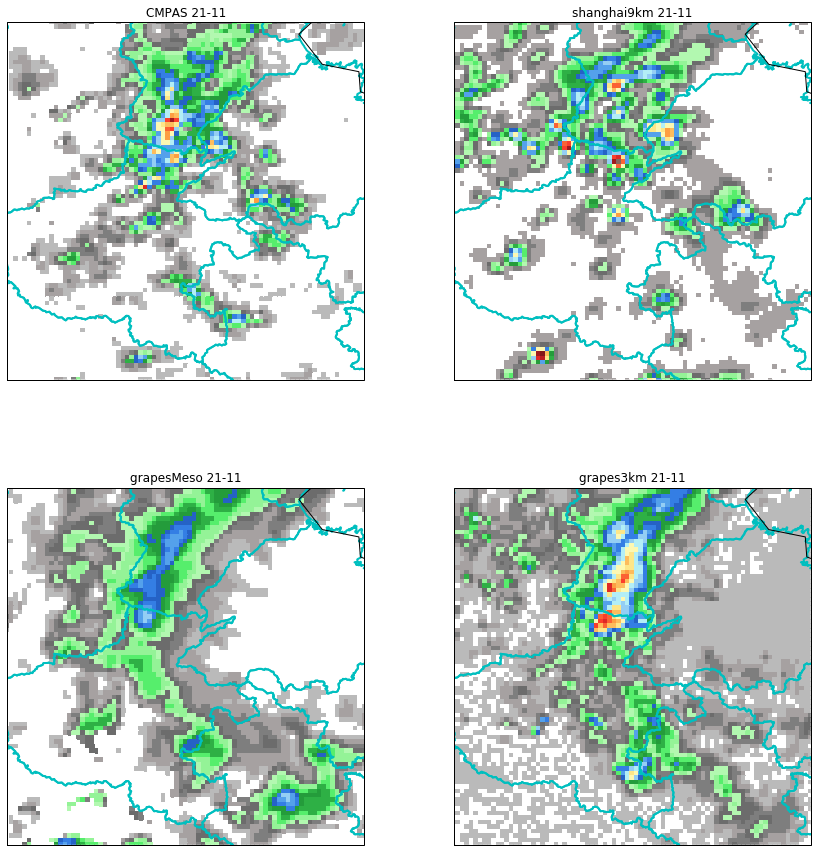

In [15]:
init_time = datetime(2018, 4, 21, 0)
fhour = 11
model_evaluation(init_time, fhour, cmpas_dir, data_dir, 
                 models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                 center=(115, 35), width=4)

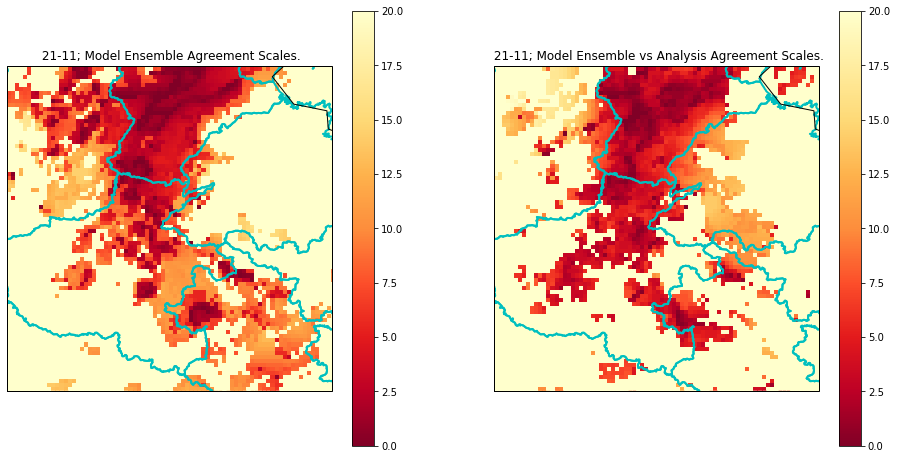

In [16]:
init_time = datetime(2018, 4, 21, 0)
fhour = 11
EAS(init_time, fhour, cmpas_dir, data_dir, center=(115, 35), width=4)

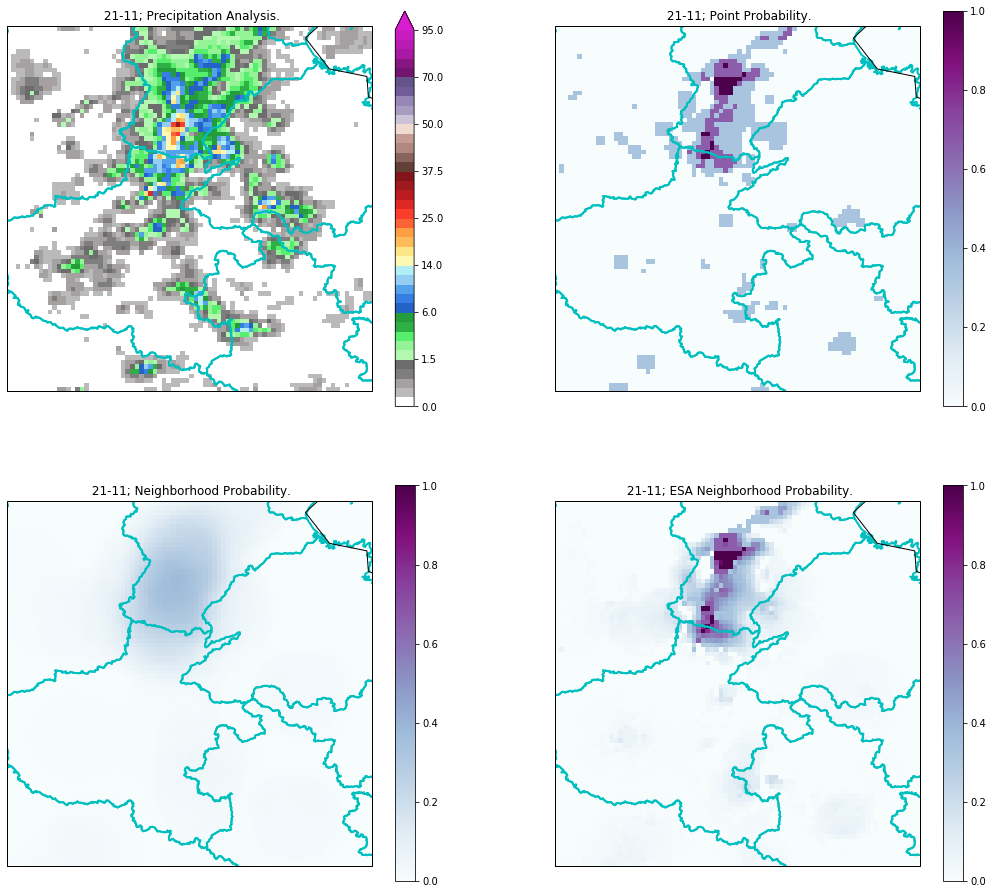

In [19]:
init_time = datetime(2018, 4, 21, 0)
fhour = 11
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(115, 35), width=4, threshold=6)

## 2018年4月22日长江中游强降水过程

(110, 118, 26.6, 34.6)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180424042312_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018042211.rain.nc
I:\Level_01\shanghai9km\2018042200\shanghai9km_tp_20180422000011.nc
I:\Level_01\grapesMeso\2018042200\grapesMeso_tp_20180422000011.nc
I:\Level_01\grapes3km\2018042200\grapes3km_tp_20180422000011.nc


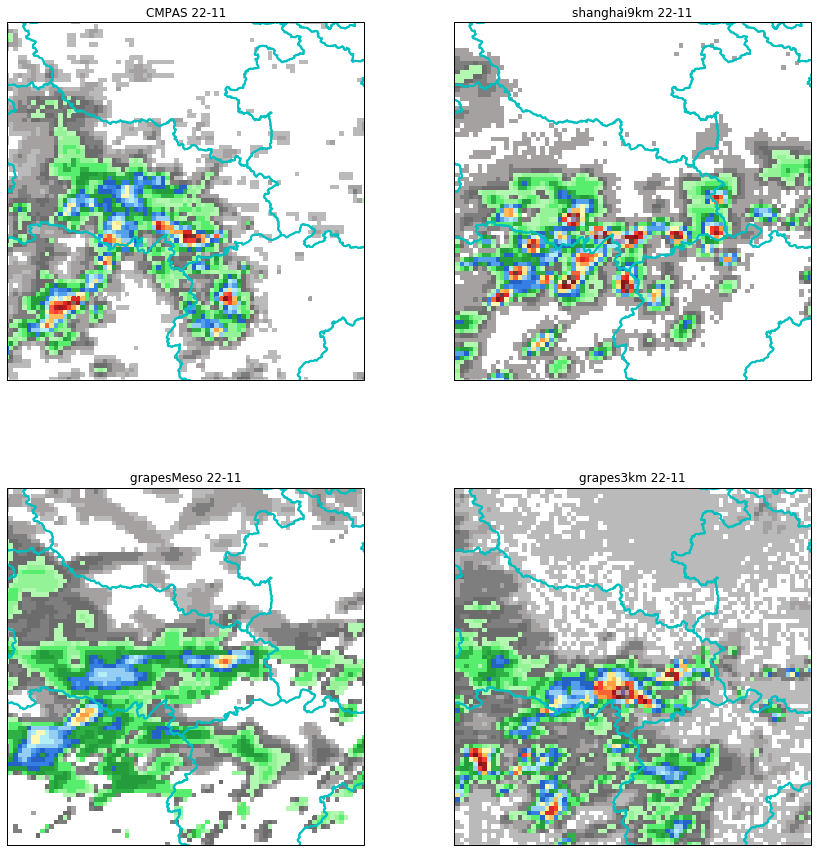

In [21]:
init_time = datetime(2018, 4, 22, 0)
fhour = 11
model_evaluation(init_time, fhour, cmpas_dir, data_dir, 
                 center=(114, 30.6), width=4)

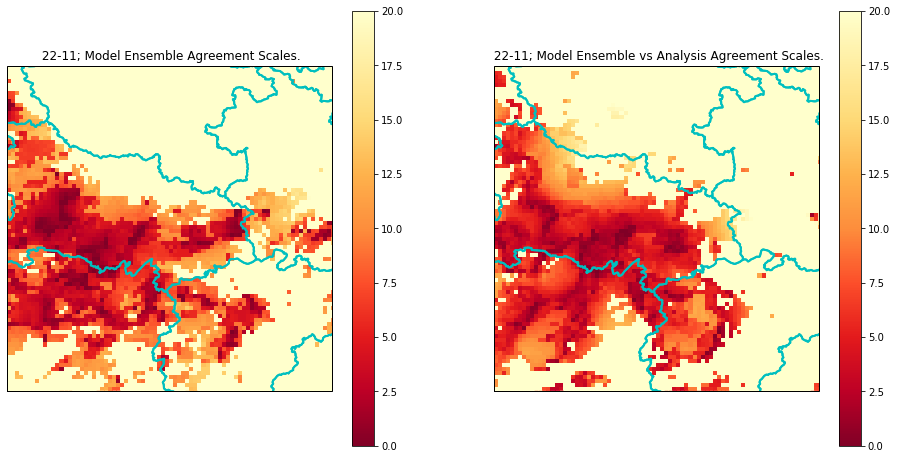

In [22]:
init_time = datetime(2018, 4, 22, 0)
fhour = 11
EAS(init_time, fhour, cmpas_dir, data_dir, center=(114, 30.6), width=4)

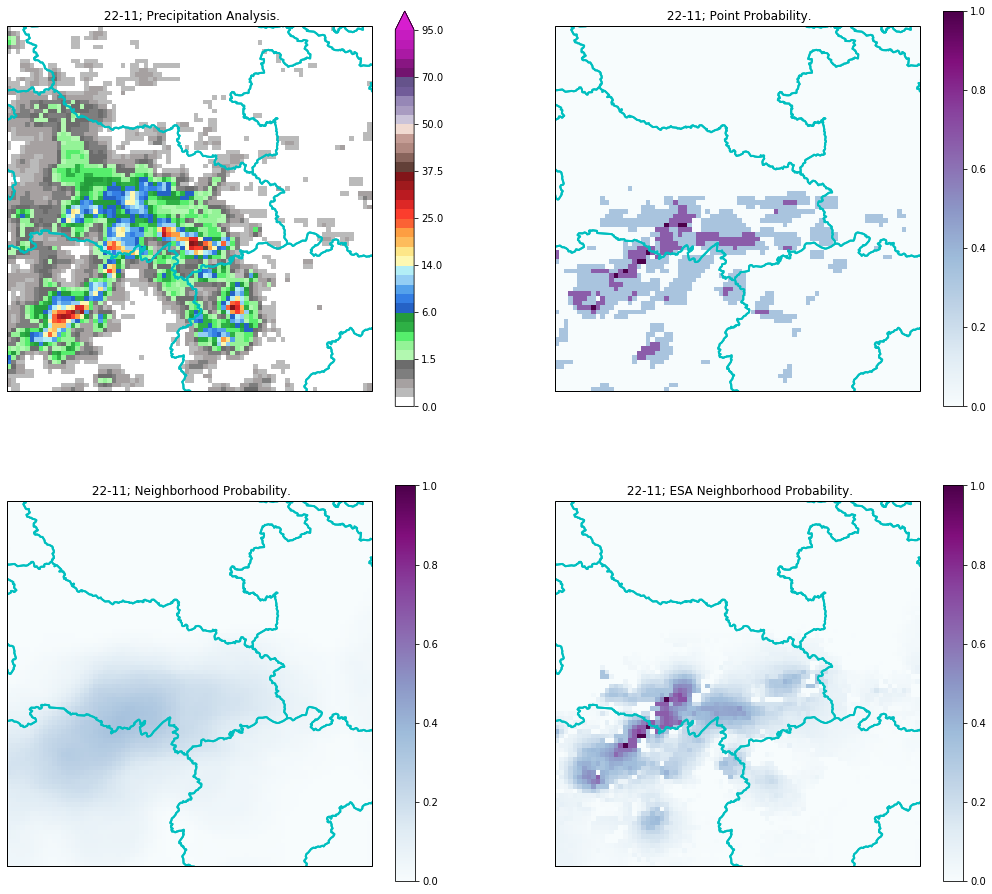

In [23]:
init_time = datetime(2018, 4, 22, 0)
fhour = 11
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(114, 30.6), width=4, threshold=6)

## 2018年5月5日长江中游强降水过程

(110, 118, 26.6, 34.6)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180507085407_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018050523.rain.nc
I:\Level_01\shanghai9km\2018050512\shanghai9km_tp_20180505120011.nc
I:\Level_01\grapesMeso\2018050512\grapesMeso_tp_20180505120011.nc
I:\Level_01\grapes3km\2018050512\grapes3km_tp_20180505120011.nc


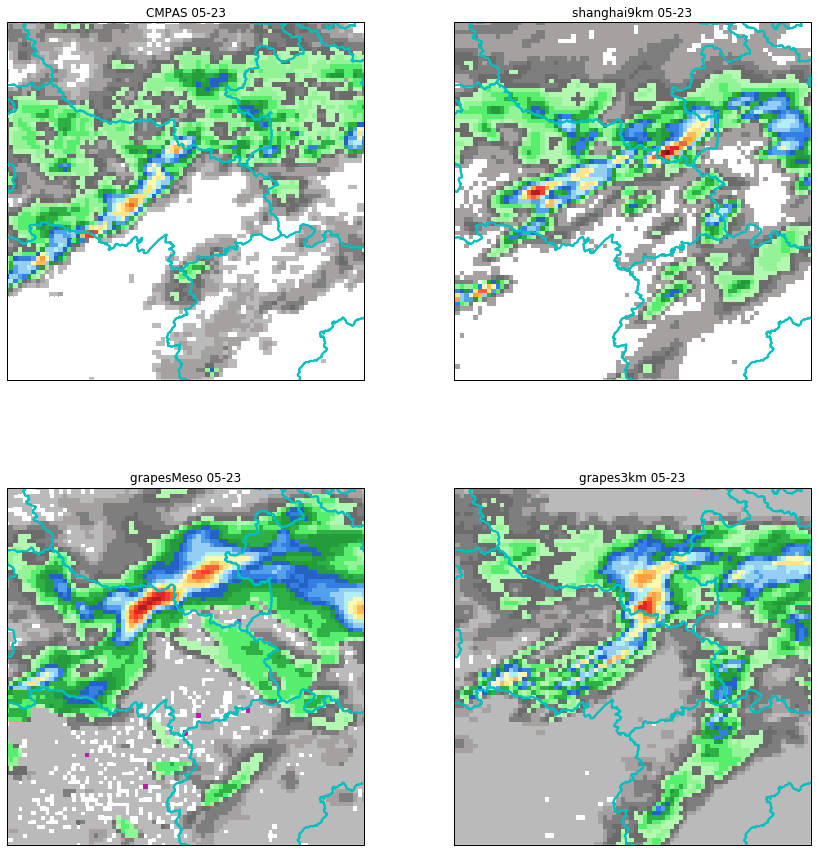

In [24]:
init_time = datetime(2018, 5, 5, 12)
fhour = 11
model_evaluation(init_time, fhour, cmpas_dir, data_dir, center=(114, 30.6), width=4)

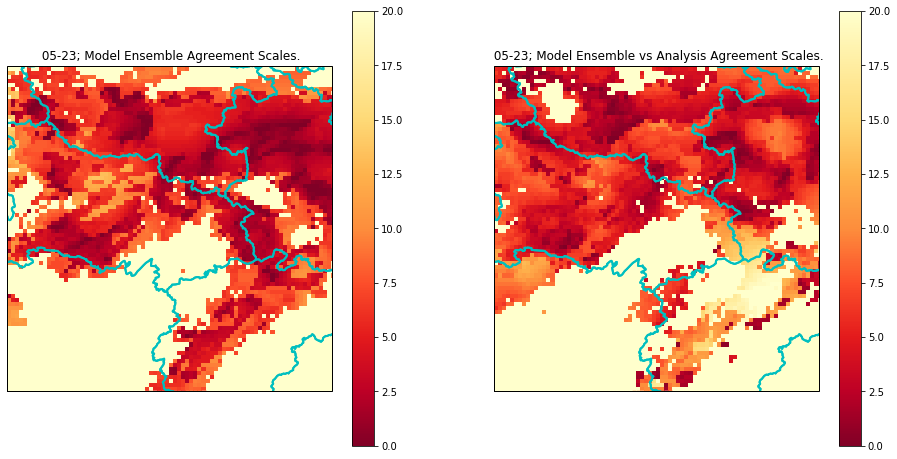

In [25]:
init_time = datetime(2018, 5, 5, 12)
fhour = 11
EAS(init_time, fhour, cmpas_dir, data_dir, center=(114, 30.6), width=4)

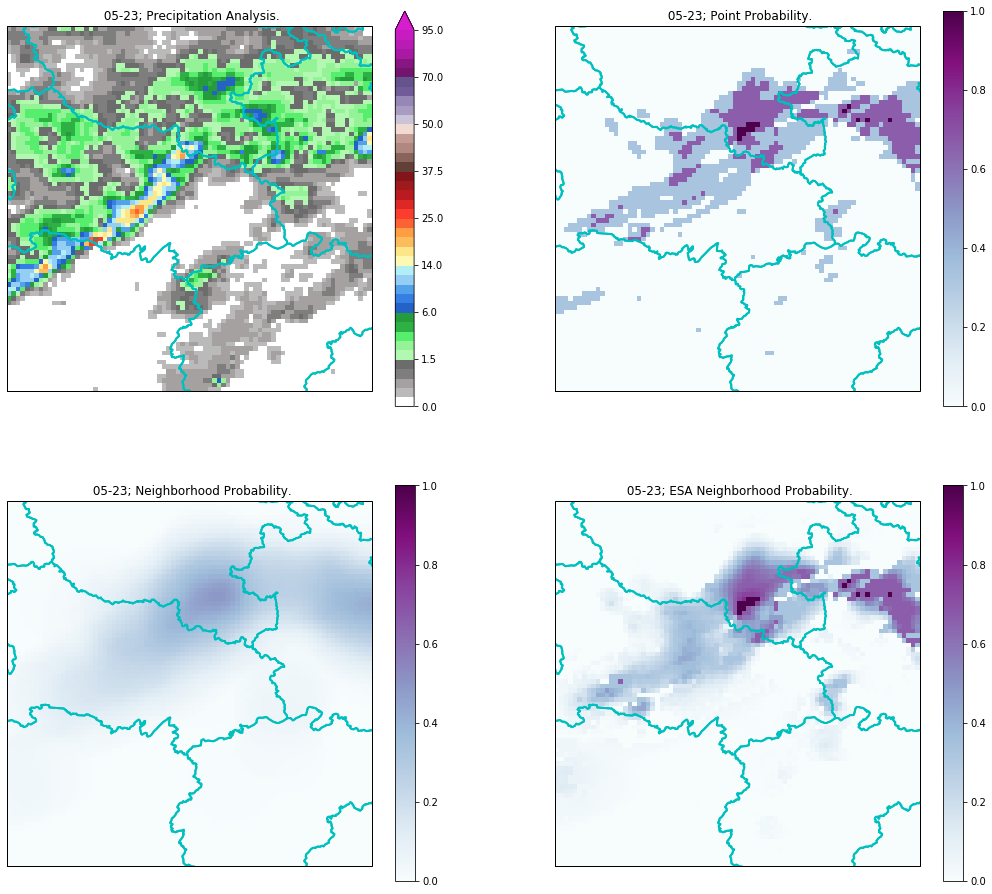

In [26]:
init_time = datetime(2018, 5, 5, 12)
fhour = 11
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(114, 30.6), width=4, threshold=6)

## 2018年6月5日江南东部强降水过程

(111.7, 121.7, 21.1, 31.1)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180607023329_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018060512.rain.nc
I:\Level_01\shanghai9km\2018060500\shanghai9km_tp_20180605000012.nc
I:\Level_01\grapesMeso\2018060500\grapesMeso_tp_20180605000012.nc
I:\Level_01\grapes3km\2018060500\grapes3km_tp_20180605000012.nc


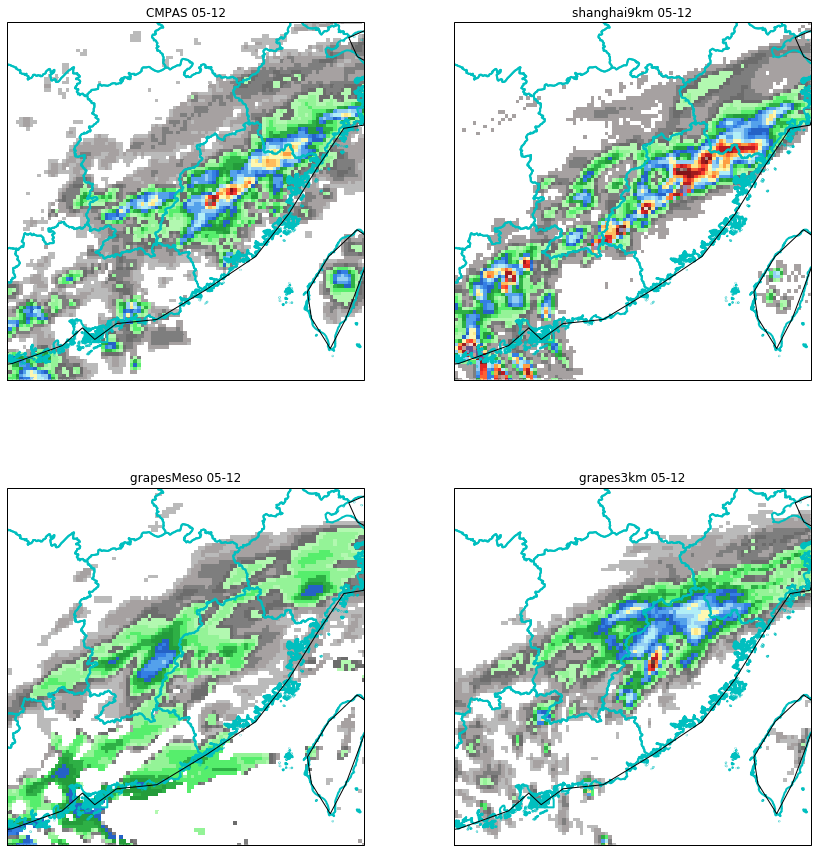

In [28]:
init_time = datetime(2018, 6, 5, 0)
fhour = 12
model_evaluation(init_time, fhour, cmpas_dir, data_dir, center=(116.7, 26.1), width=5)

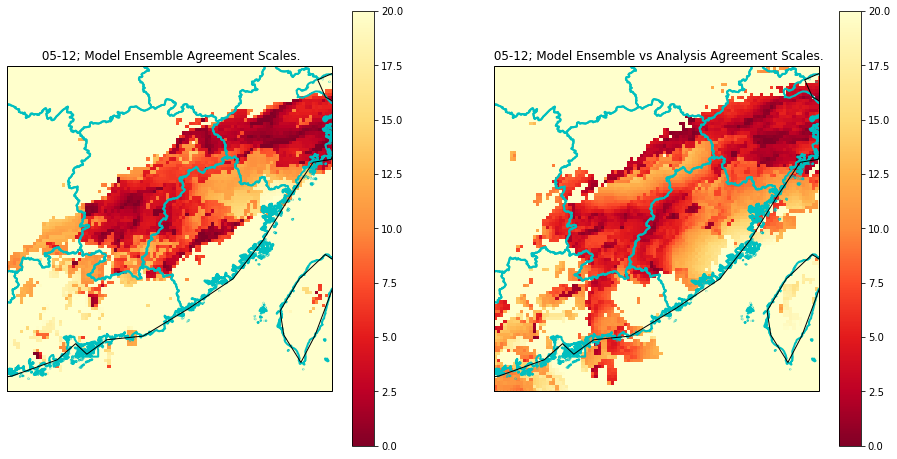

In [29]:
init_time = datetime(2018, 6, 5, 0)
fhour = 12
EAS(init_time, fhour, cmpas_dir, data_dir, center=(116.7, 26.1), width=5)

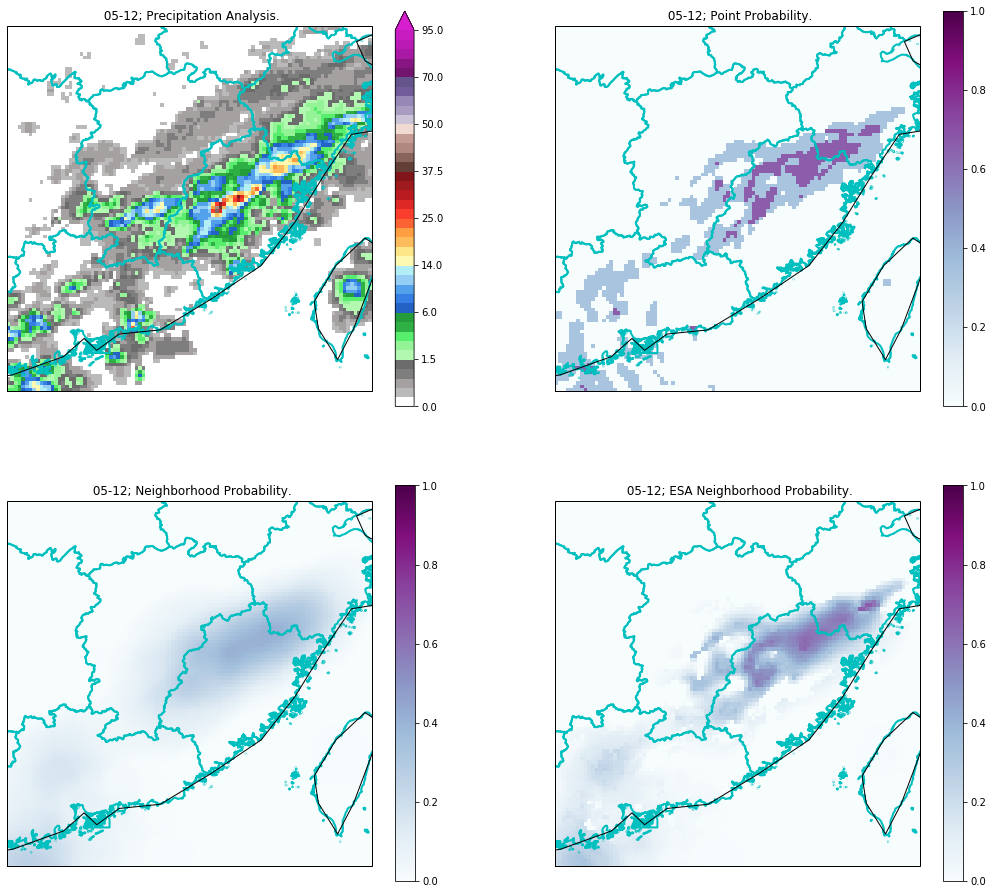

In [30]:
init_time = datetime(2018, 6, 5, 0)
fhour = 12i
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(116.7, 26.1), width=5, threshold=6)

## 2018年5月22日西南地区东部强降水过程

(104.2, 112.2, 25.8, 33.8)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180524005634_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018052203.rain.nc
I:\Level_01\shanghai9km\2018052112\shanghai9km_tp_20180521120015.nc
I:\Level_01\grapesMeso\2018052112\grapesMeso_tp_20180521120015.nc
I:\Level_01\grapes3km\2018052112\grapes3km_tp_20180521120015.nc


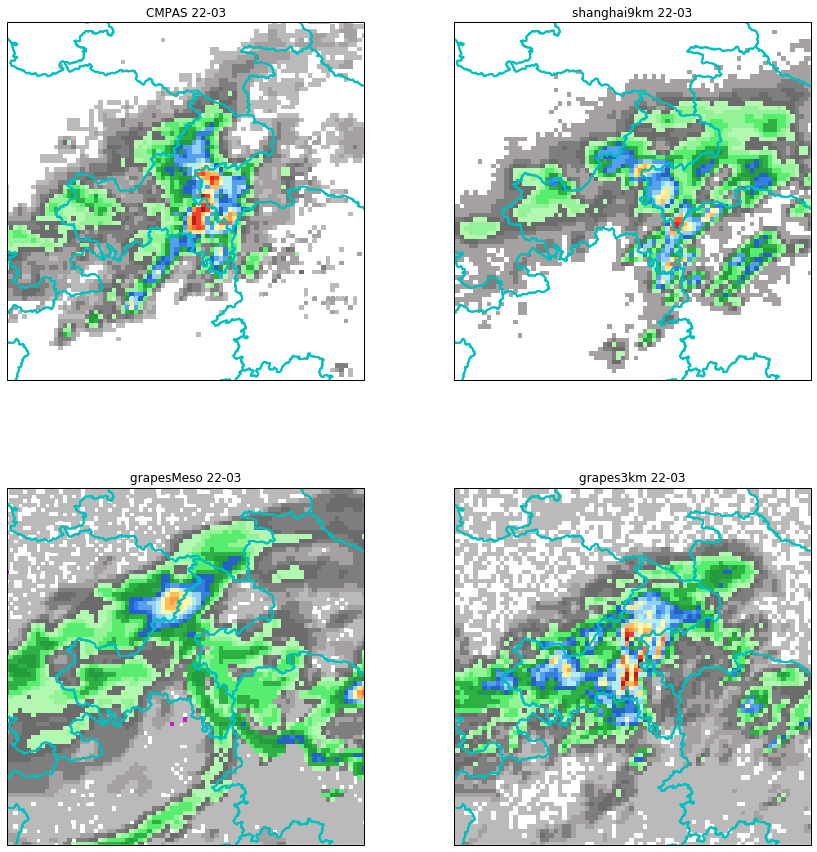

In [27]:
init_time = datetime(2018, 5, 21, 12)
fhour = 15
model_evaluation(init_time, fhour, cmpas_dir, data_dir, center=(108.2, 29.8), width=4)

##  2018年6月7日华南台风艾云尼降水

(109.5, 117.5, 19.9, 27.9)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180609034239_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018060716.rain.nc
I:\Level_01\shanghai9km\2018060700\shanghai9km_tp_20180607000016.nc
I:\Level_01\grapesMeso\2018060700\grapesMeso_tp_20180607000016.nc
I:\Level_01\grapes3km\2018060700\grapes3km_tp_20180607000016.nc


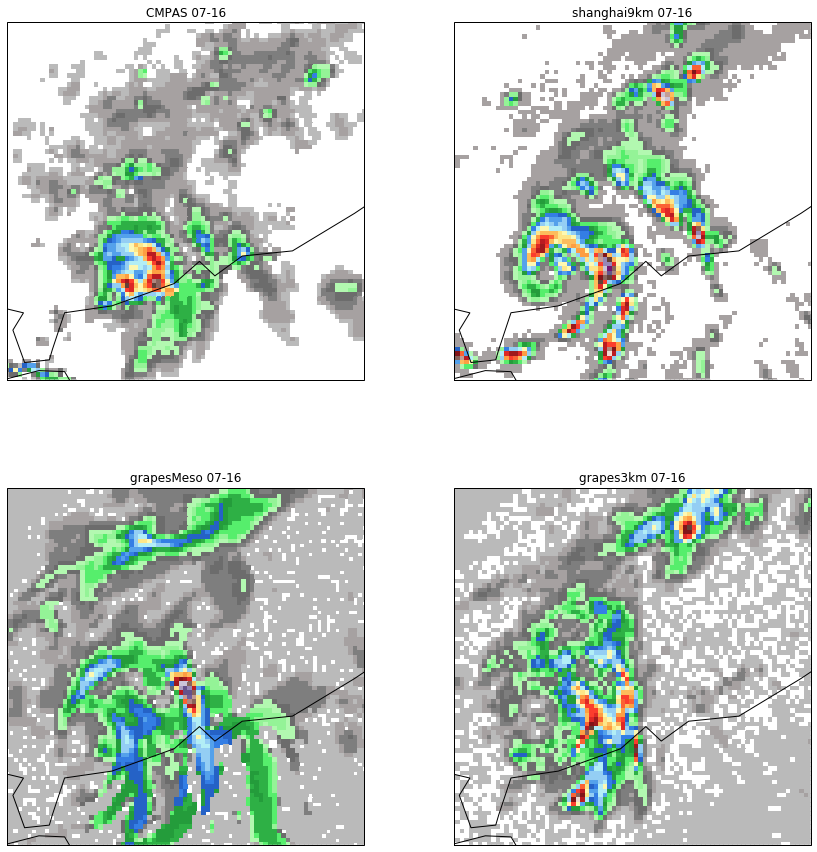

In [36]:
init_time = datetime(2018, 6, 7, 0)
model_evaluation(init_time, 16, cmpas_dir, data_dir, 
                 models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                 center=(113.5, 23.9), width=4)

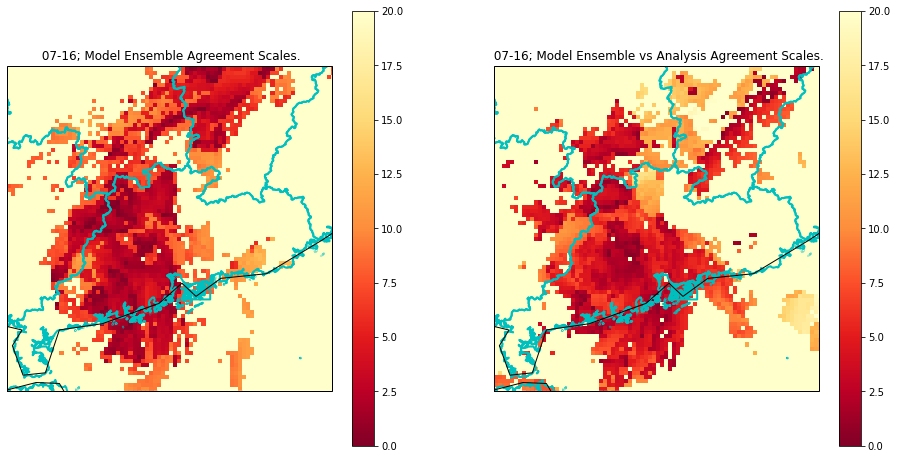

In [12]:
init_time = datetime(2018, 6, 7, 0)
fhour = 16
EAS(init_time, fhour, cmpas_dir, data_dir, center=(113.5, 23.9), width=4)

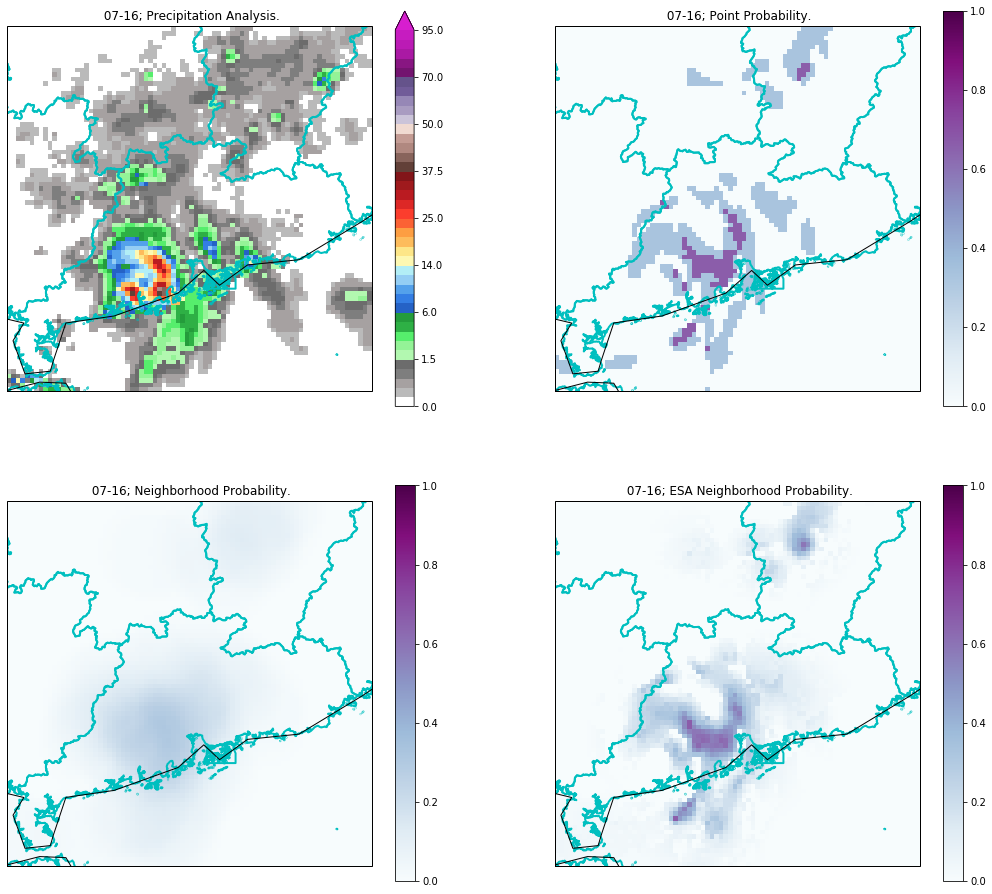

In [9]:
init_time = datetime(2018, 6, 7, 0)
fhour = 16
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(113.5, 23.9), width=4)

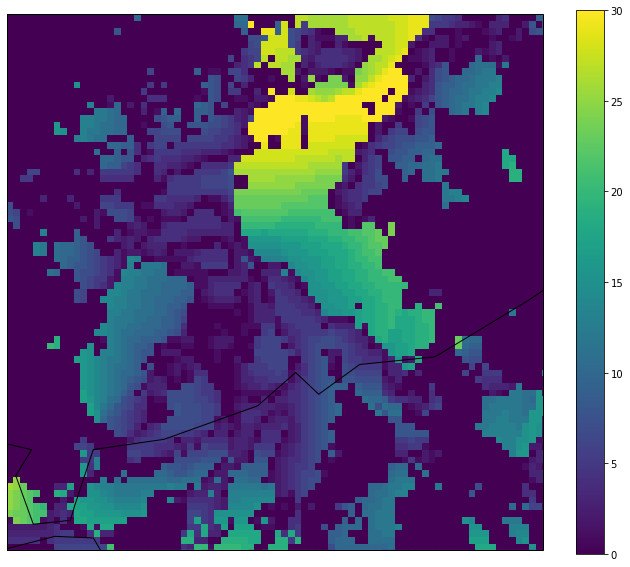

In [57]:
field1 = xr.open_dataset("I:/CMPAS/2018/0P10/Z_SURF_C_BABJ_20180609034239_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018060716.rain.nc")
field1 = field1.isel(latitude=slice(None, None, -1))
field2 = xr.open_dataset("I:/Level_01/shanghai9km/2018060700/shanghai9km_tp_20180607000016.nc")

lon = field1.coords['longitude'].values
lat = field1.coords['latitude'].values
f1 = np.squeeze(field1.rain.values)
f2 = np.squeeze(field2.tp.values)
Af12 = agreement_scales(f1, f2, lon, lat, S_limit=60, alpha=0.1)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((109.5, 117.5, 19.9, 27.9), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(lon, lat, Af12, vmax=30, transform=ccrs.PlateCarree())
plt.colorbar(cm)
ax.coastlines()

## 2018年6月17日四川盆地东北部强降水

(105, 113, 28.1, 36.1)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180619043905_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018061722.rain.nc
I:\Level_01\shanghai9km\2018061712\shanghai9km_tp_20180617120010.nc
I:\Level_01\grapesMeso\2018061712\grapesMeso_tp_20180617120010.nc
I:\Level_01\grapes3km\2018061712\grapes3km_tp_20180617120010.nc


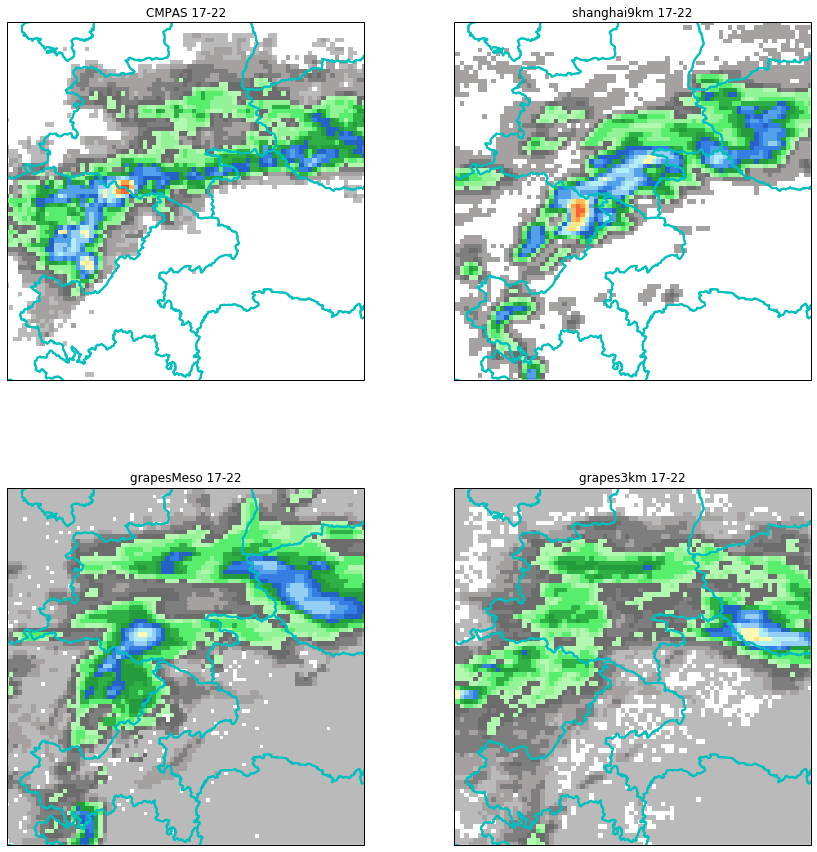

In [31]:
init_time = datetime(2018, 6, 17, 12)
model_evaluation(init_time, 10, cmpas_dir, data_dir, 
                 models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                 center=(109, 32.1), width=4)

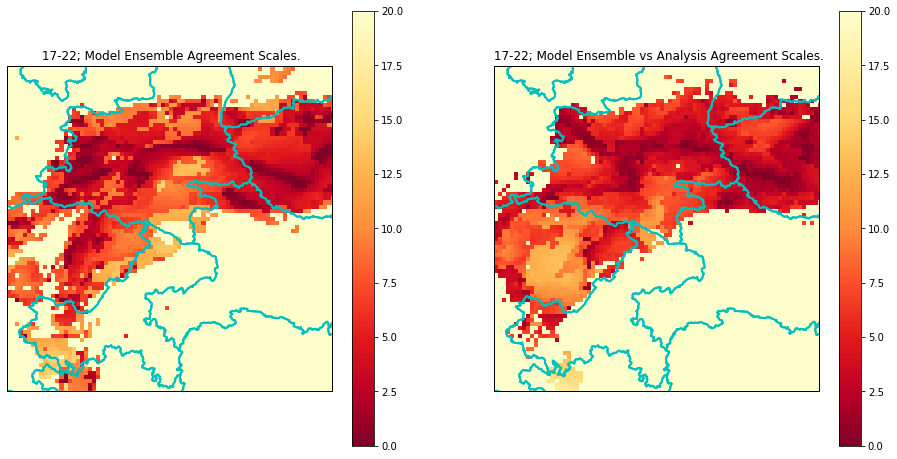

In [32]:
init_time = datetime(2018, 6, 17, 12)
fhour = 10
EAS(init_time, fhour, cmpas_dir, data_dir, center=(109, 32.1), width=4)

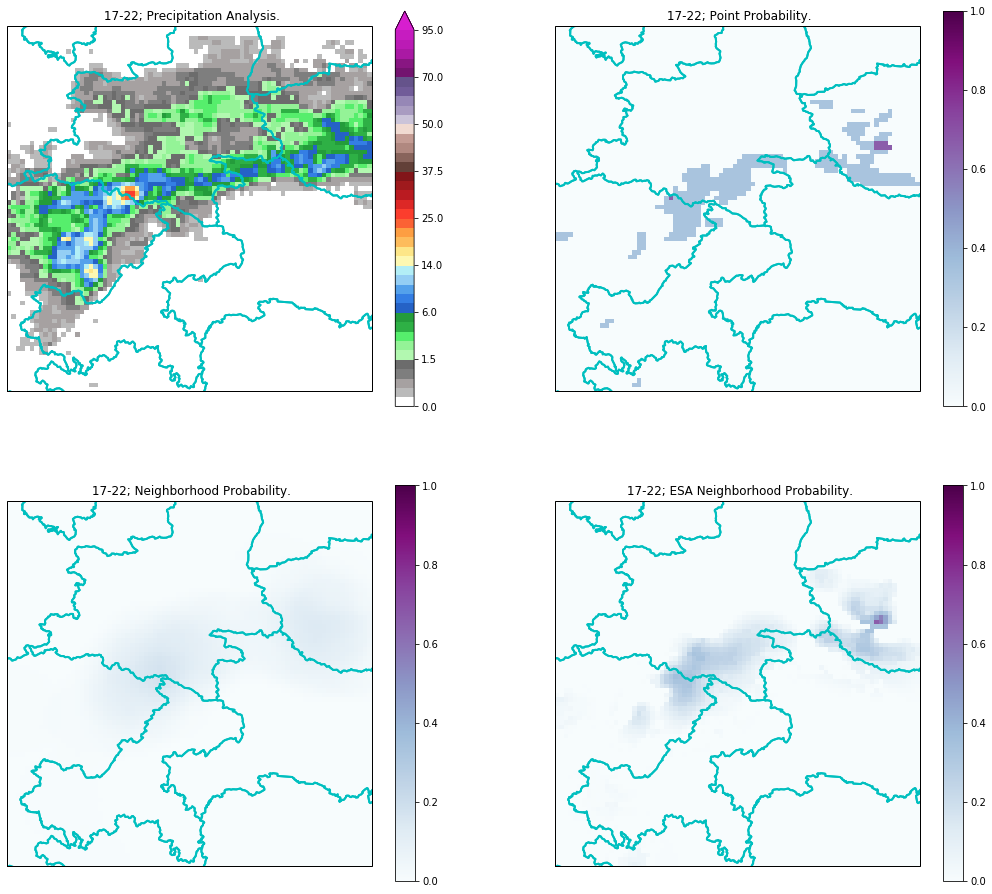

In [33]:
init_time = datetime(2018, 6, 17, 12)
fhour = 10
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(109, 32.1), width=4)

## 2018年6月25日山东强降水

(113.7, 121.7, 32.7, 40.7)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180627025204_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018062513.rain.nc
I:\Level_01\shanghai9km\2018062500\shanghai9km_tp_20180625000013.nc
I:\Level_01\grapesMeso\2018062500\grapesMeso_tp_20180625000013.nc
I:\Level_01\grapes3km\2018062500\grapes3km_tp_20180625000013.nc


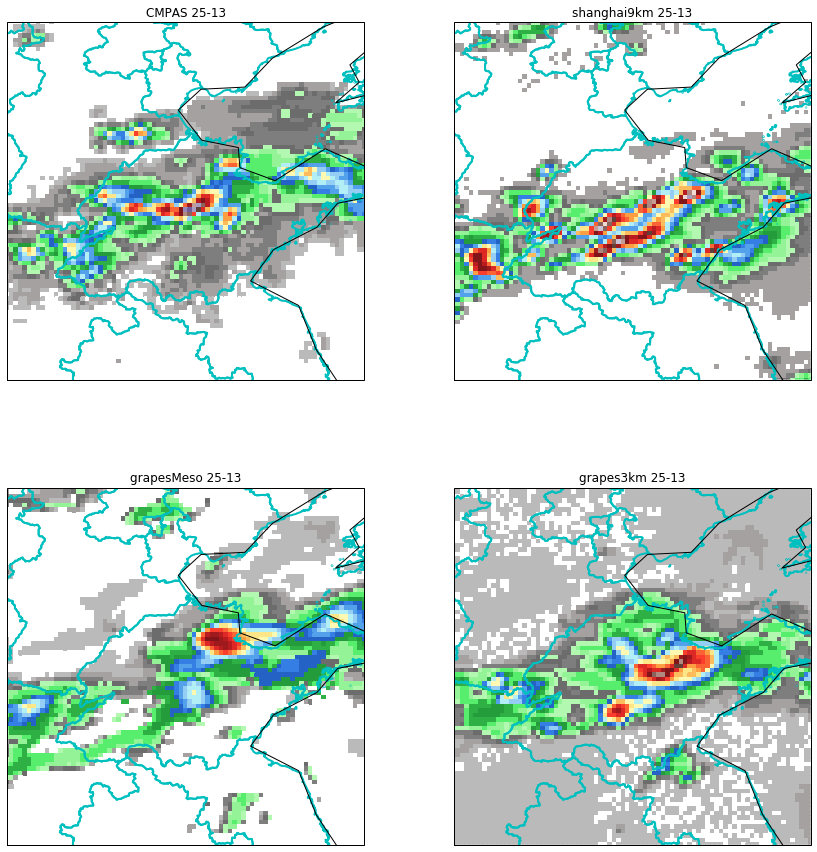

In [34]:
init_time = datetime(2018, 6, 25, 0)
model_evaluation(init_time, 13, cmpas_dir, data_dir, 
                 models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                 center=(117.7, 36.7), width=4)

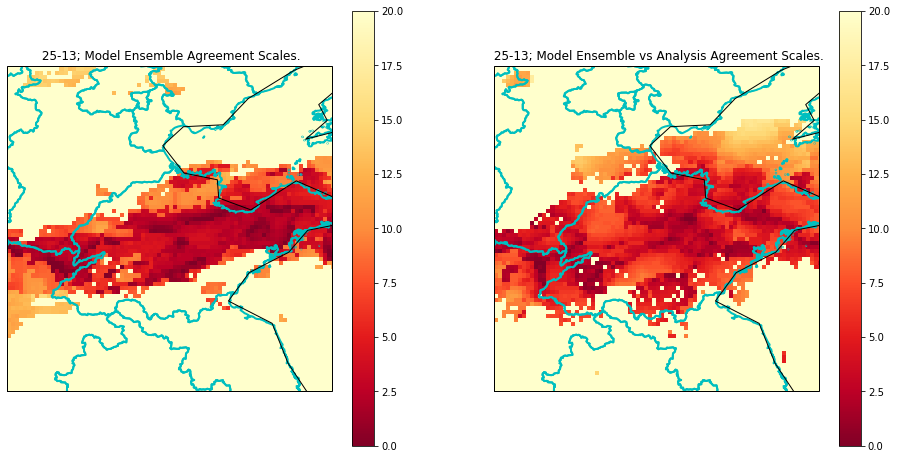

In [35]:
init_time = datetime(2018, 6, 25, 0)
fhour = 13
EAS(init_time, fhour, cmpas_dir, data_dir, center=(117.7, 36.7), width=4)

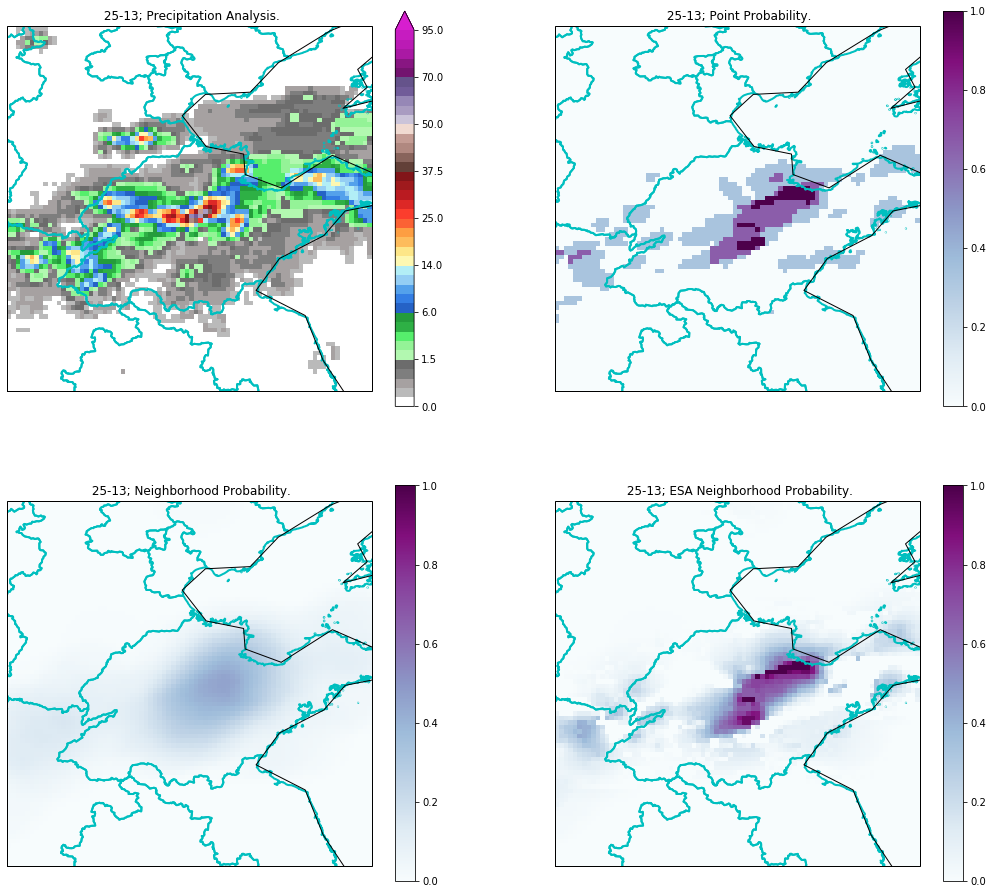

In [36]:
init_time = datetime(2018, 6, 25, 0)
fhour = 13
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(117.7, 36.7), width=4)

## 2018年7月1日西北地区强降水过程

(100, 108, 32, 40)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180703030326_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018070114.rain.nc
I:\Level_01\shanghai9km\2018070100\shanghai9km_tp_20180701000014.nc
I:\Level_01\grapesMeso\2018070100\grapesMeso_tp_20180701000014.nc
I:\Level_01\grapes3km\2018070100\grapes3km_tp_20180701000014.nc


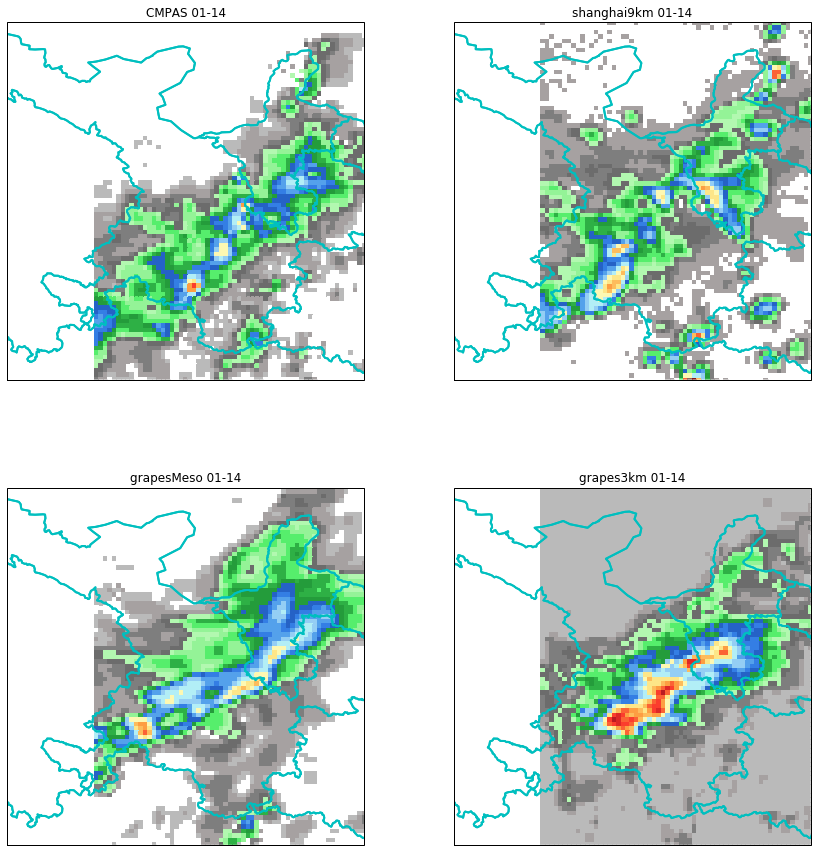

In [38]:
init_time = datetime(2018, 7, 1, 0)
model_evaluation(init_time, 14, cmpas_dir, data_dir, 
                 models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                 center=(104, 36), width=4)

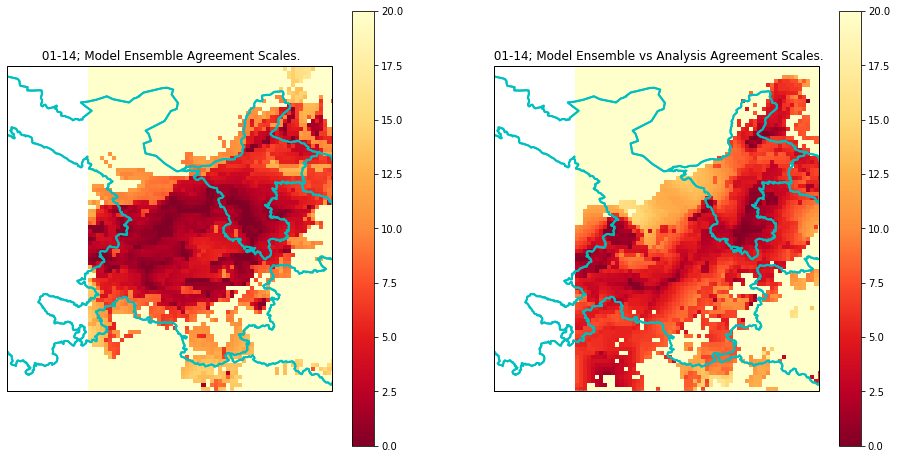

In [39]:
init_time = datetime(2018, 7, 1, 0)
fhour = 14
EAS(init_time, fhour, cmpas_dir, data_dir, center=(104, 36), width=4)

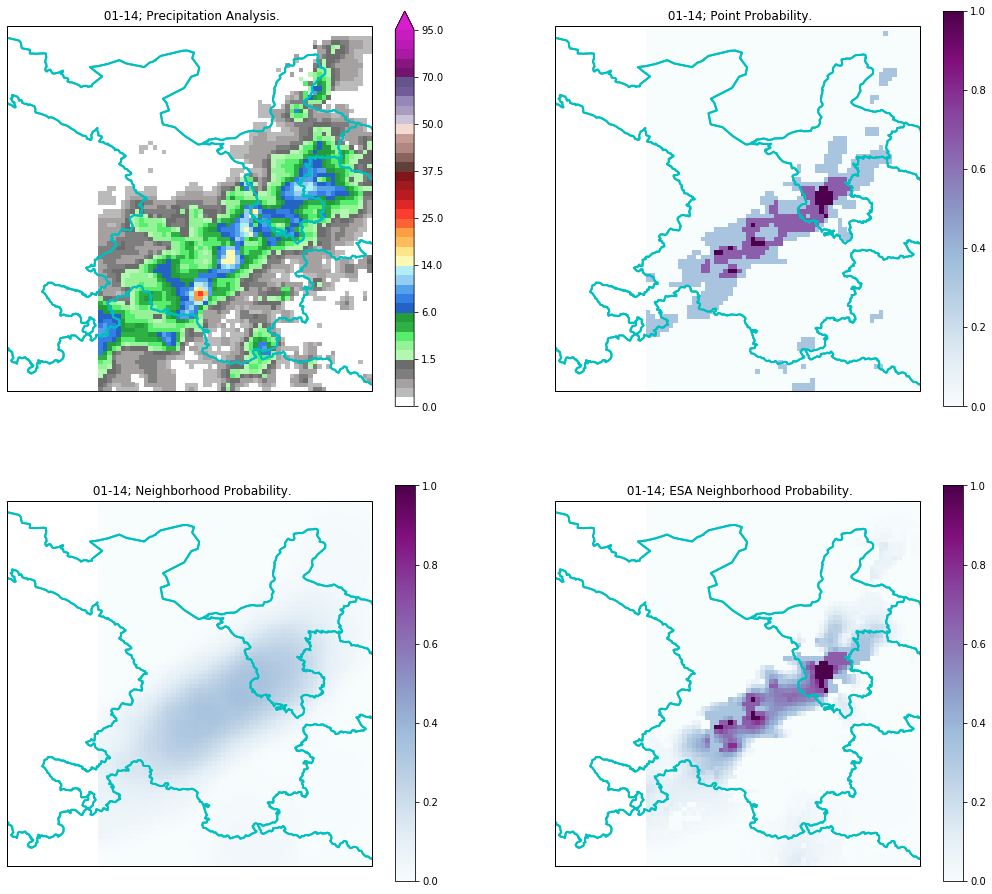

In [40]:
init_time = datetime(2018, 7, 1, 0)
fhour = 14
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(104, 36), width=4)

## 2018年7月10日西北地区强降水过程

(101.2, 109.2, 30.700000000000003, 38.7)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180712023839_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018071011.rain.nc
I:\Level_01\shanghai9km\2018070912\shanghai9km_tp_20180709120023.nc
I:\Level_01\grapesMeso\2018070912\grapesMeso_tp_20180709120023.nc
I:\Level_01\grapes3km\2018070912\grapes3km_tp_20180709120023.nc


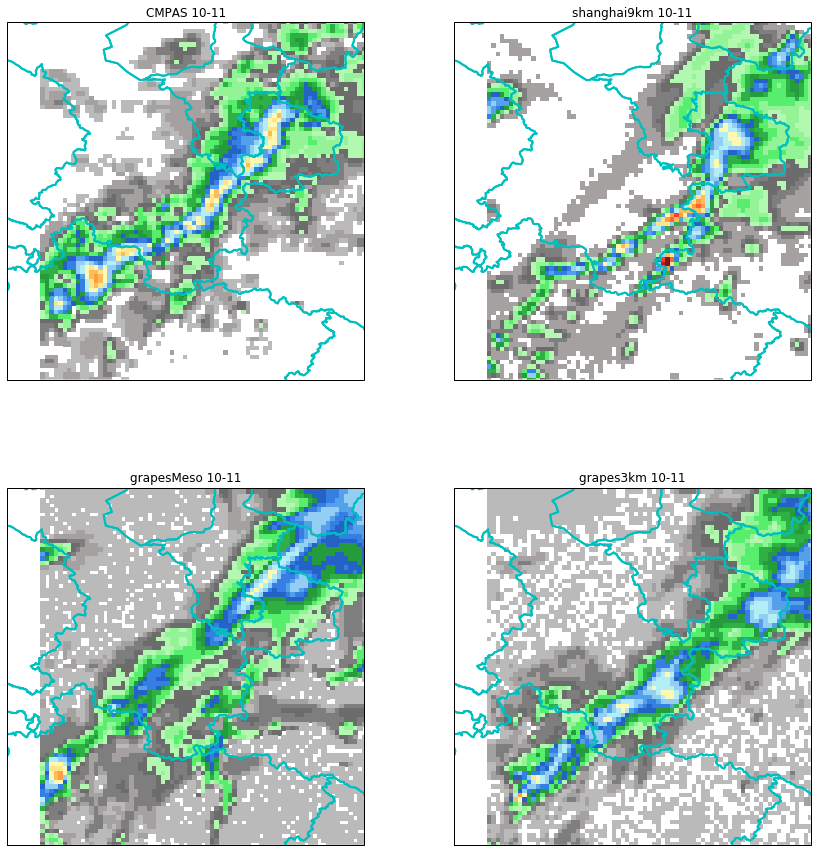

In [41]:
init_time = datetime(2018, 7, 9, 12)
model_evaluation(init_time, 23, cmpas_dir, data_dir, 
                 models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                 center=(105.2, 34.7), width=4)

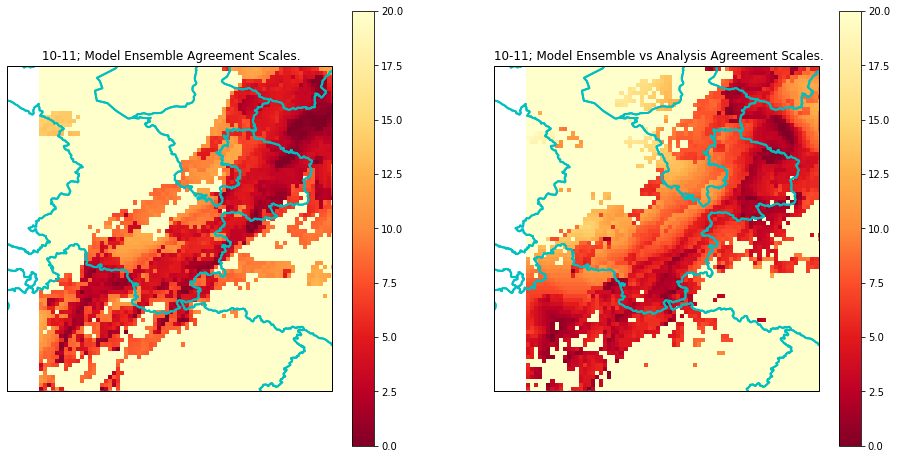

In [42]:
init_time = datetime(2018, 7, 9, 12)
fhour = 23
EAS(init_time, fhour, cmpas_dir, data_dir, center=(105.2, 34.7), width=4)

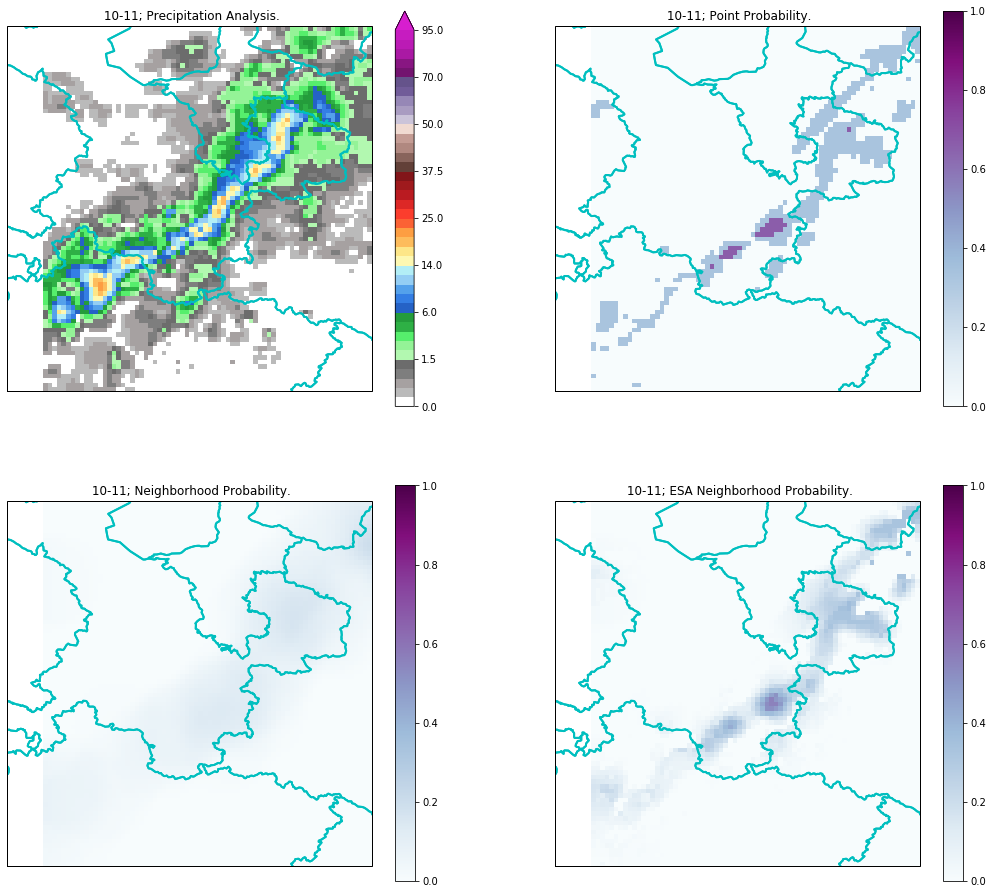

In [43]:
init_time = datetime(2018, 7, 9, 12)
fhour = 23
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(105.2, 34.7), width=4)

## 2018年7月23日台风安比给黄淮、华北带来强降水

(115.2, 123.2, 32.2, 40.2)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180725010126_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018072303.rain.nc
I:\Level_01\shanghai9km\2018072212\shanghai9km_tp_20180722120015.nc
I:\Level_01\grapesMeso\2018072212\grapesMeso_tp_20180722120015.nc
I:\Level_01\grapes3km\2018072212\grapes3km_tp_20180722120015.nc


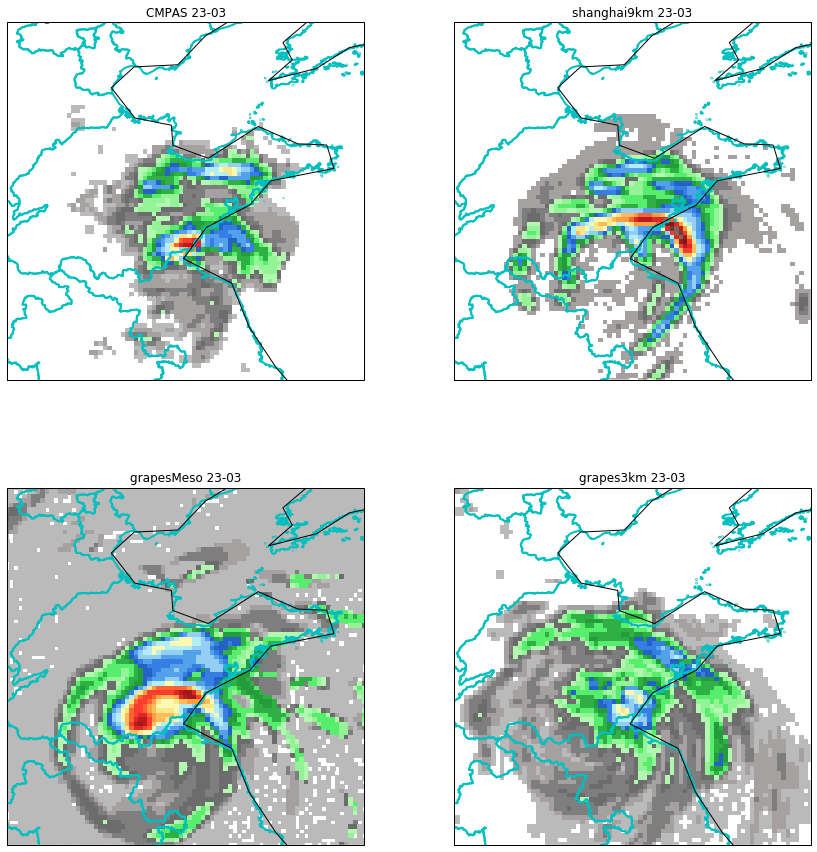

In [44]:
init_time = datetime(2018, 7, 22, 12)
model_evaluation(init_time, 15, cmpas_dir, data_dir, 
                 models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                 center=(119.2, 36.2), width=4)

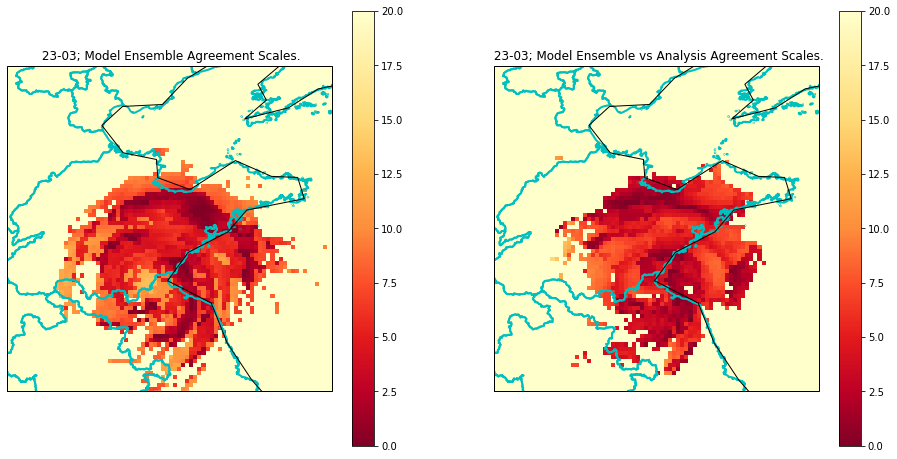

In [45]:
init_time = datetime(2018, 7, 22, 12)
fhour = 15
EAS(init_time, fhour, cmpas_dir, data_dir, center=(119.2, 36.2), width=4)

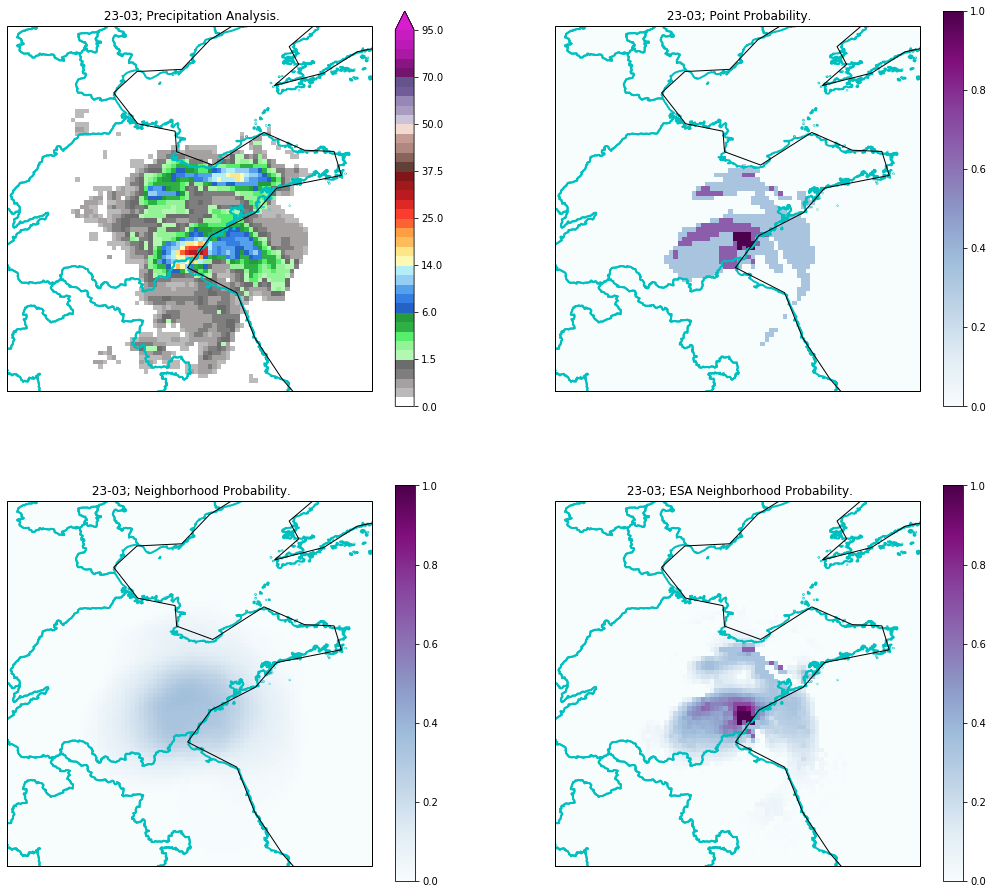

In [46]:
init_time = datetime(2018, 7, 22, 12)
fhour = 15
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(119.2, 36.2), width=4)

##  2018年7月10日四川盆地强降水

(101.3, 107.3, 28.0, 34.0)
I:\CMPAS\2018\0P10\Z_SURF_C_BABJ_20180712040012_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018071017.rain.nc
I:\Level_01\shanghai9km\2018071000\shanghai9km_tp_20180710000017.nc
I:\Level_01\grapesMeso\2018071000\grapesMeso_tp_20180710000017.nc
I:\Level_01\grapes3km\2018071000\grapes3km_tp_20180710000017.nc


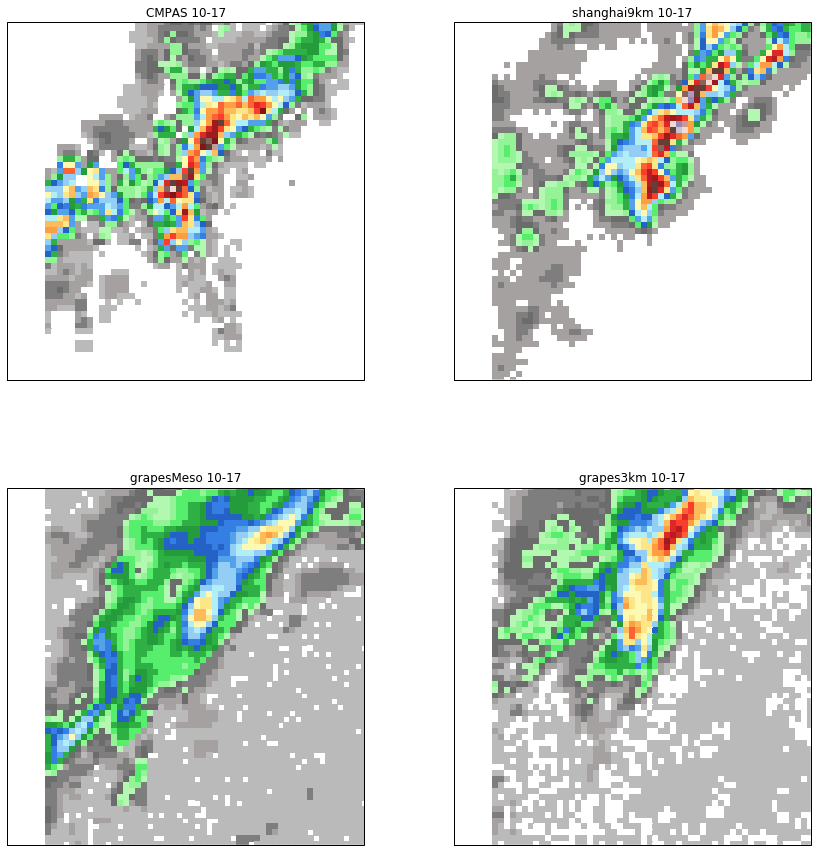

In [59]:
init_time = datetime(2018, 7, 10, 0)
model_evaluation(init_time, 17, cmpas_dir, data_dir, 
                 models=('shanghai9km', 'grapesMeso', 'grapes3km'),
                 center=(104.3, 31.0), width=3)

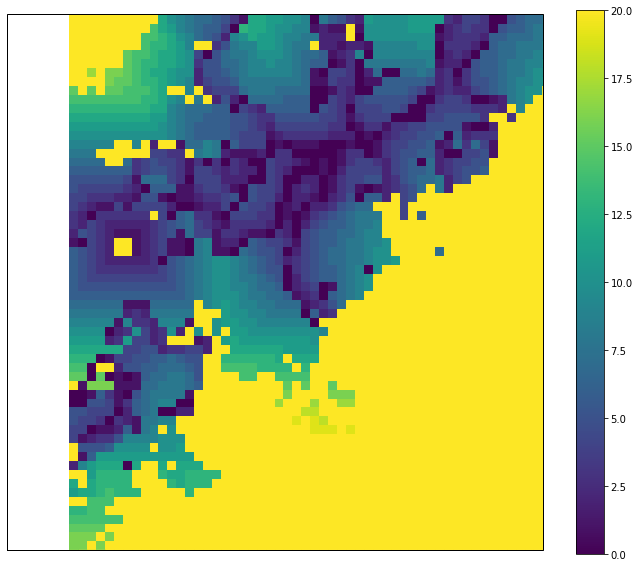

In [66]:
field1 = xr.open_dataset("I:\\CMPAS\\2018\\0P10\\Z_SURF_C_BABJ_20180712040012_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018071017.rain.nc")
field1 = field1.isel(latitude=slice(None, None, -1))
field2 = xr.open_dataset("I:\\Level_01\\shanghai9km\\2018071000\\shanghai9km_tp_20180710000017.nc")

lon = field1.coords['longitude'].values
lat = field1.coords['latitude'].values
f1 = np.squeeze(field1.rain.values)
f2 = np.squeeze(field2.tp.values)
Af12 = agreement_scales(f1, f2, lon, lat, S_limit=60, alpha=0.05)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(lon, lat, Af12, vmax=20, transform=ccrs.PlateCarree())
plt.colorbar(cm)
ax.coastlines()

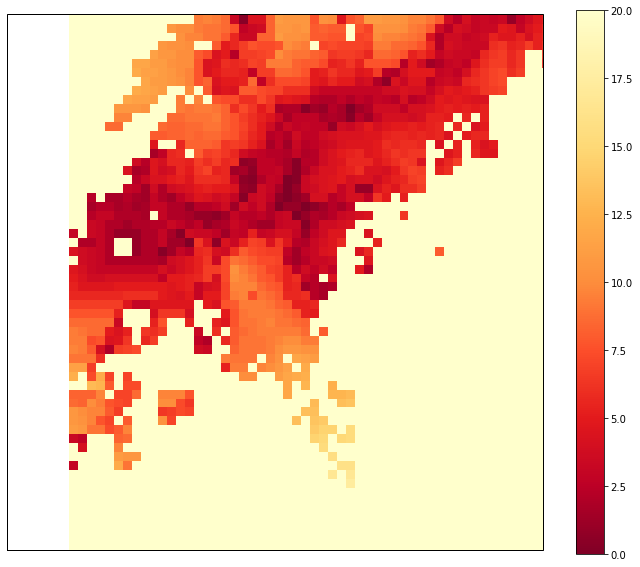

In [73]:
field1 = xr.open_dataset("I:\\CMPAS\\2018\\0P10\\Z_SURF_C_BABJ_20180712040012_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018071017.rain.nc")
field1 = field1.isel(latitude=slice(None, None, -1))
lon = field1.coords['longitude'].values
lat = field1.coords['latitude'].values
f1 = np.squeeze(field1.rain.values)

field2 = xr.open_dataset("I:\\Level_01\\shanghai9km\\2018071000\\shanghai9km_tp_20180710000017.nc")
f2 = np.squeeze(field2.tp.values)
Af12 = agreement_scales(f1, f2, lon, lat, S_limit=60, alpha=0.1)

field3 = xr.open_dataset("I:\\Level_01\\grapesMeso\\2018071000\\grapesMeso_tp_20180710000017.nc")
field3 = field3.isel(latitude=slice(None, None, -1))
f3 =  np.squeeze(field3.tp.values)
Af13 = agreement_scales(f1, f3, lon, lat, S_limit=60, alpha=0.1)

field4 = xr.open_dataset("I:\\Level_01\\grapes3km\\2018071000\\grapes3km_tp_20180710000017.nc")
field4 = field4.isel(latitude=slice(None, None, -1))
f4 =  np.squeeze(field4.tp.values)
Af14 = agreement_scales(f1, f4, lon, lat, S_limit=60, alpha=0.1)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(lon, lat, (Af12+Af13+Af14)/3.0, cmap=plt.cm.YlOrRd_r, vmax=20, transform=ccrs.PlateCarree())
plt.colorbar(cm)
ax.coastlines()

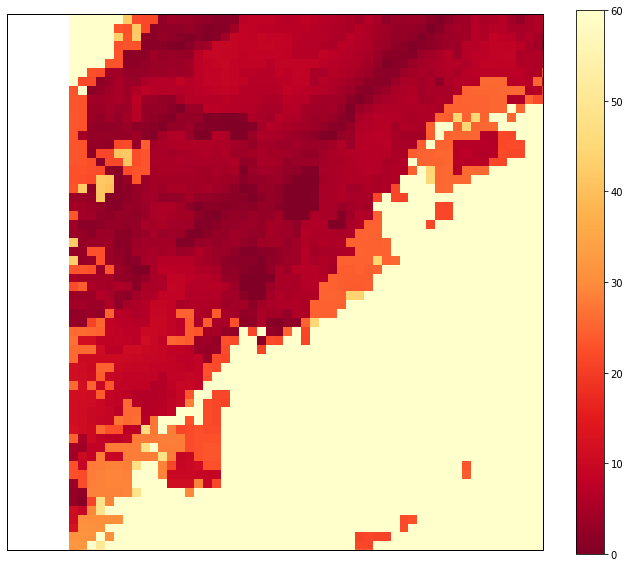

In [81]:
Af = ensemble_agreement_scales(np.stack((f2,f3,f4)), lon, lat, S_limit=60, alpha=0.1)
plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(lon, lat, Af, cmap=plt.cm.YlOrRd_r, vmax=60, transform=ccrs.PlateCarree())
plt.colorbar(cm)
ax.coastlines()

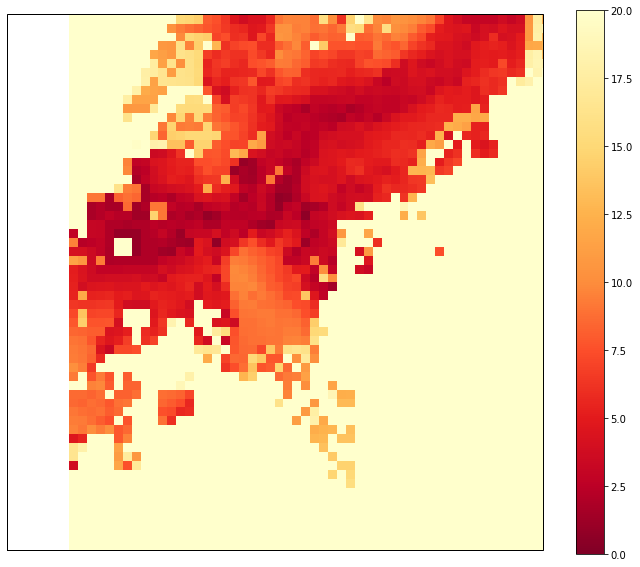

In [82]:
field1 = xr.open_dataset("I:\\CMPAS\\2018\\0P10\\Z_SURF_C_BABJ_20180712040012_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018071017.rain.nc")
field1 = field1.isel(latitude=slice(None, None, -1))
lon = field1.coords['longitude'].values
lat = field1.coords['latitude'].values
f1 = np.squeeze(field1.rain.values)

field2 = xr.open_dataset("I:\\Level_01\\shanghai9km\\2018071000\\shanghai9km_tp_20180710000017.nc")
f2 = np.squeeze(field2.tp.values)
Af12 = agreement_scales(f1, f2, lon, lat, S_limit=60, alpha=0.1)

field3 = xr.open_dataset("I:\\Level_01\\grapesMeso\\2018071000\\grapesMeso_tp_20180710000017.nc")
field3 = field3.isel(latitude=slice(None, None, -1))
f3 =  np.squeeze(field3.tp.values)
Af13 = agreement_scales(f1, f3, lon, lat, S_limit=60, alpha=0.1)

field4 = xr.open_dataset("I:\\Level_01\\grapes3km\\2018071000\\grapes3km_tp_20180710000017.nc")
field4 = field4.isel(latitude=slice(None, None, -1))
f4 =  np.squeeze(field4.tp.values)
Af14 = agreement_scales(f1, f4, lon, lat, S_limit=60, alpha=0.1)

field5 = xr.open_dataset("I:\\Level_01\\shanghai9km\\2018071000\\shanghai9km_tp_20180710000016.nc")
f5 = np.squeeze(field5.tp.values)
Af15 = agreement_scales(f1, f5, lon, lat, S_limit=60, alpha=0.1)

field6 = xr.open_dataset("I:\\Level_01\\grapesMeso\\2018071000\\grapesMeso_tp_20180710000016.nc")
field6 = field6.isel(latitude=slice(None, None, -1))
f6 =  np.squeeze(field6.tp.values)
Af16 = agreement_scales(f1, f6, lon, lat, S_limit=60, alpha=0.1)

field7 = xr.open_dataset("I:\\Level_01\\grapes3km\\2018071000\\grapes3km_tp_20180710000016.nc")
field7 = field7.isel(latitude=slice(None, None, -1))
f7 =  np.squeeze(field7.tp.values)
Af17 = agreement_scales(f1, f7, lon, lat, S_limit=60, alpha=0.1)

field8 = xr.open_dataset("I:\\Level_01\\shanghai9km\\2018071000\\shanghai9km_tp_20180710000018.nc")
f8 = np.squeeze(field8.tp.values)
Af18 = agreement_scales(f1, f8, lon, lat, S_limit=60, alpha=0.1)

field9 = xr.open_dataset("I:\\Level_01\\grapesMeso\\2018071000\\grapesMeso_tp_20180710000018.nc")
field9 = field9.isel(latitude=slice(None, None, -1))
f9 =  np.squeeze(field9.tp.values)
Af19 = agreement_scales(f1, f9, lon, lat, S_limit=60, alpha=0.1)

field10 = xr.open_dataset("I:\\Level_01\\grapes3km\\2018071000\\grapes3km_tp_20180710000018.nc")
field10 = field10.isel(latitude=slice(None, None, -1))
f10 =  np.squeeze(field10.tp.values)
Af110 = agreement_scales(f1, f10, lon, lat, S_limit=60, alpha=0.1)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(lon, lat, (Af12+Af13+Af14+Af15+Af16+Af17+Af18+Af19+Af110)/9.0, cmap=plt.cm.YlOrRd_r, vmax=20, transform=ccrs.PlateCarree())
plt.colorbar(cm)
ax.coastlines()

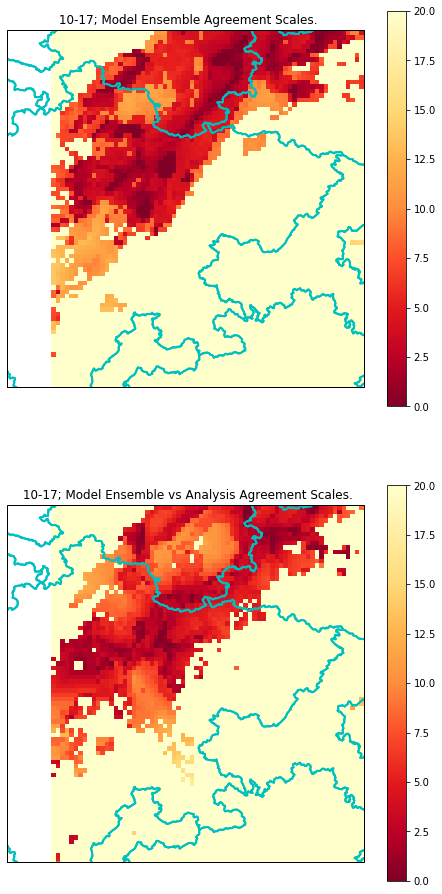

In [14]:
init_time = datetime(2018, 7, 10, 0)
fhour = 17
EAS(init_time, fhour, cmpas_dir, data_dir, center=(105, 31), width=4)

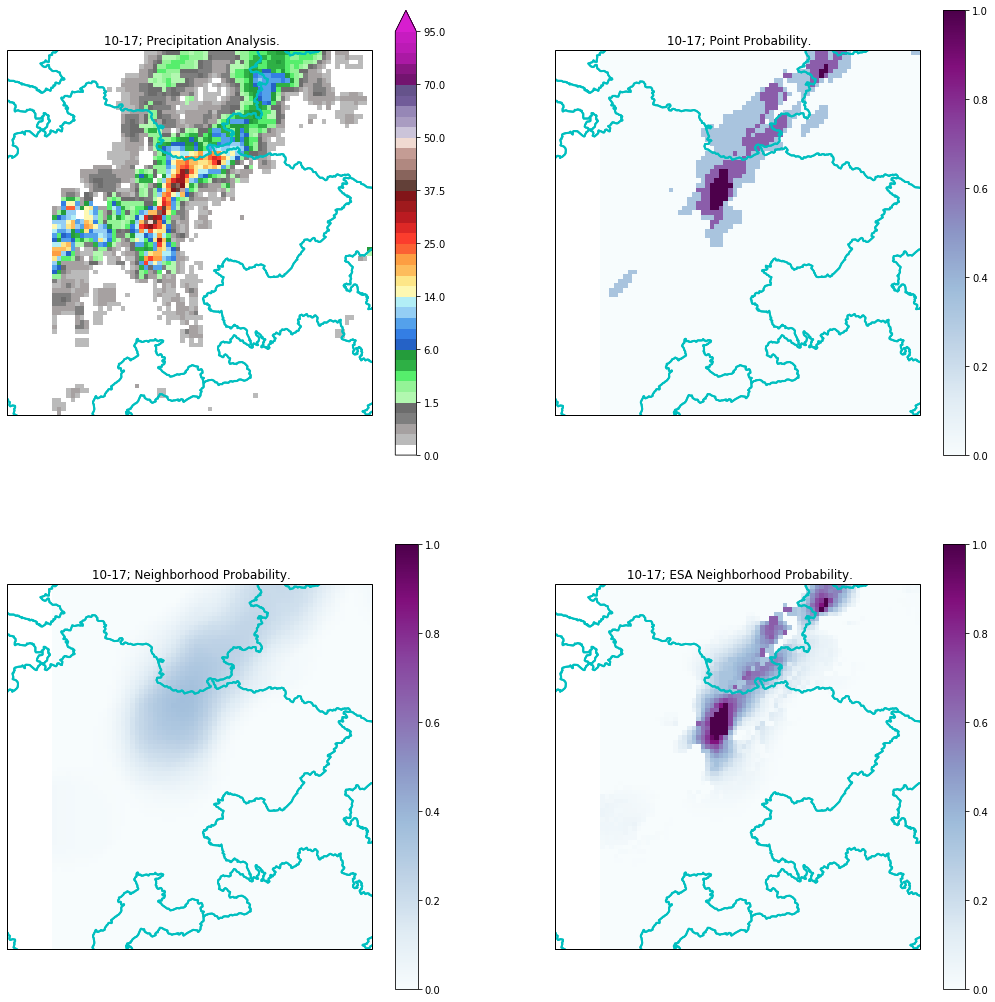

In [9]:
init_time = datetime(2018, 7, 10, 0)
fhour = 17
prob = nhood_prob(init_time, fhour, cmpas_dir, data_dir, center=(105, 31), width=4)

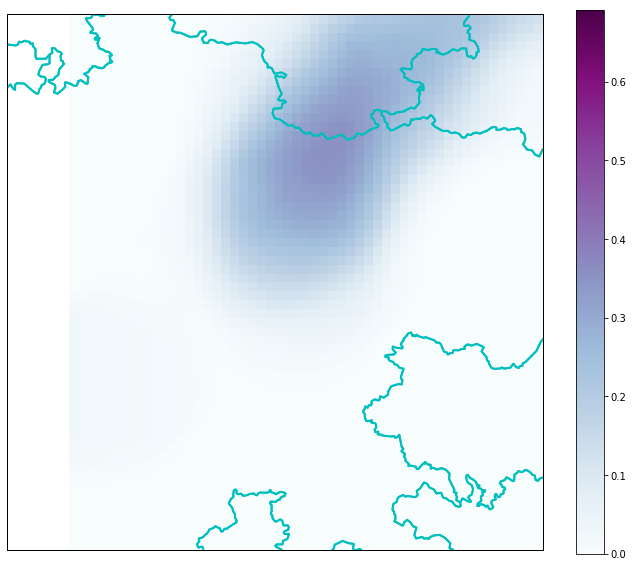

In [44]:
plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(prob['lon'], prob['lat'], prob['fields_prob'], cmap=plt.cm.BuPu, transform=ccrs.PlateCarree())
add_china_map_2cartopy(ax)
plt.colorbar(cm)
ax.coastlines()

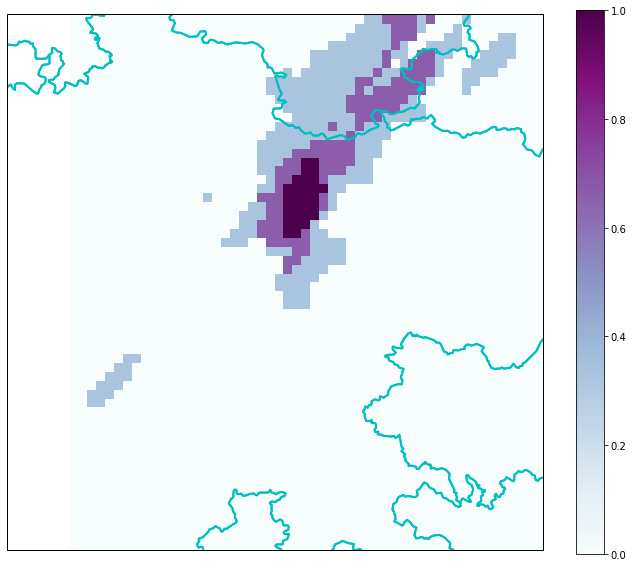

In [45]:
plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(prob['lon'], prob['lat'], prob['fields_prob_point'], cmap=plt.cm.BuPu, transform=ccrs.PlateCarree())
add_china_map_2cartopy(ax)
plt.colorbar(cm)
ax.coastlines()

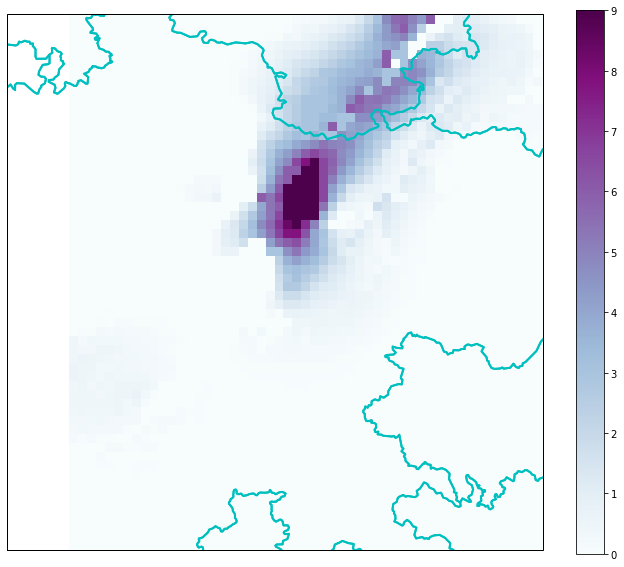

In [51]:
plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(prob['lon'], prob['lat'], prob['fields_prob_esa'], cmap=plt.cm.BuPu, transform=ccrs.PlateCarree())
add_china_map_2cartopy(ax)
plt.colorbar(cm)
ax.coastlines()

In [33]:
field = xr.open_dataset("I:\\Level_01\\shanghai9km\\2018071000\\shanghai9km_tp_20180710000017.nc")
lon = field.coords['longitude']
lat = field.coords['latitude']
fcst = np.squeeze(field.tp.values)

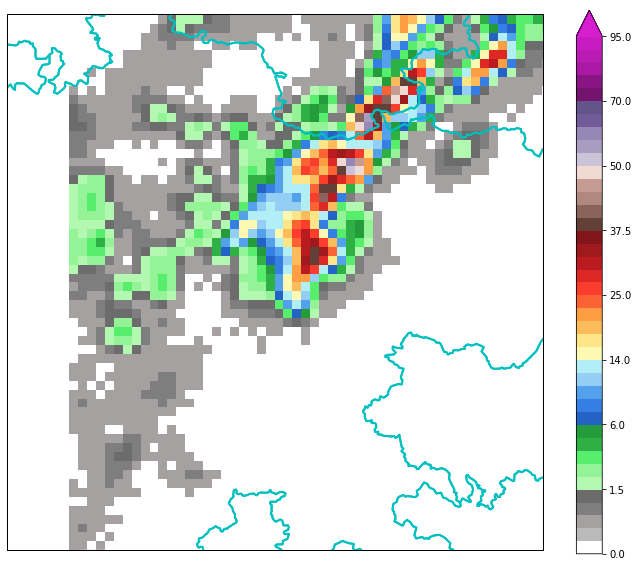

In [65]:
plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cmap, norm = cm_qpf_nws(atime=1)
cm = ax.pcolormesh(lon, lat, fcst, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
add_china_map_2cartopy(ax, color='black')
plt.colorbar(cm)
ax.coastlines()


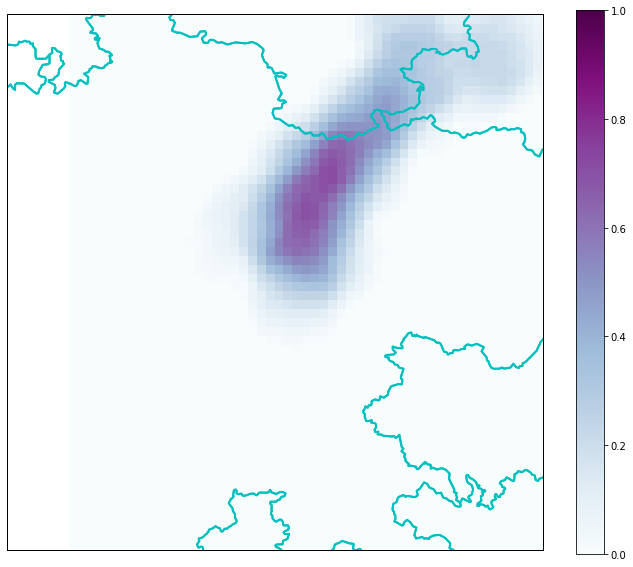

In [100]:
prob = nhood2D(fcst, 12, radius=5)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(lon, lat, prob, cmap=plt.cm.BuPu, transform=ccrs.PlateCarree())
add_china_map_2cartopy(ax, color='black')
plt.colorbar(cm)
ax.coastlines()

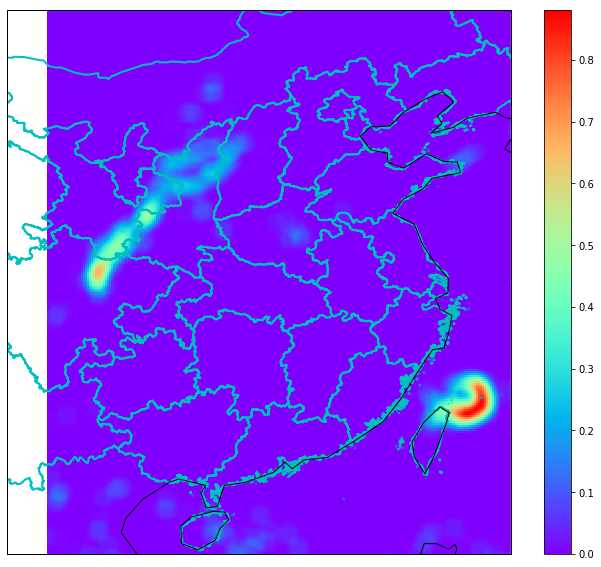

In [105]:
prob = nhood3D(fields, 8, radius=5)

plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent((101.3, 107.3, 28.0, 34.0), crs=ccrs.PlateCarree())
ax.set_extent((100, 125, 18.0, 45.0), crs=ccrs.PlateCarree())
cm = ax.pcolormesh(lon, lat, prob, cmap=plt.cm.rainbow, transform=ccrs.PlateCarree())
add_china_map_2cartopy(ax, color='black')
plt.colorbar(cm)
ax.coastlines()

## 空间不确定性分析

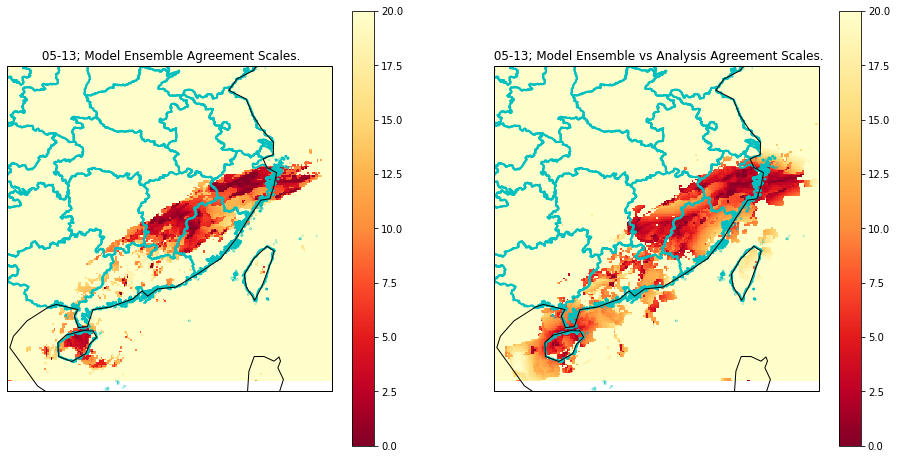

In [48]:
init_time = datetime(2018, 6, 5, 0)
fhour = 13
EAS(init_time, fhour, cmpas_dir, data_dir, center=(115.5, 26.4), width=10)